# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.6840049281401672 -2.8673615010954663
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [17]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
                                                                                       shape=[-1, 1])))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [18]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [19]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [20]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [21]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [22]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [23]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [24]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ),
)
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
#         # Break episode/epoch loop
#         if np.mean(episodes_total_reward) >= 500:
#             break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR.ckpt')

Episode:0 meanR:308.0000 gloss:0.0086 dloss:0.6918 dlossR:0.6918 dlossQ:0.6932
Episode:1 meanR:172.5000 gloss:0.0378 dloss:0.7172 dlossR:0.7172 dlossQ:0.6929
Episode:2 meanR:125.6667 gloss:0.0318 dloss:0.7138 dlossR:0.7138 dlossQ:0.6930
Episode:3 meanR:104.2500 gloss:0.0185 dloss:0.7047 dlossR:0.7047 dlossQ:0.6932
Episode:4 meanR:89.2000 gloss:0.0062 dloss:0.6969 dlossR:0.6969 dlossQ:0.6932
Episode:5 meanR:80.0000 gloss:-0.0062 dloss:0.6888 dlossR:0.6888 dlossQ:0.6932
Episode:6 meanR:73.7143 gloss:-0.0131 dloss:0.6843 dlossR:0.6843 dlossQ:0.6931
Episode:7 meanR:67.3750 gloss:-0.0298 dloss:0.6723 dlossR:0.6723 dlossQ:0.6929
Episode:8 meanR:62.1111 gloss:-0.0459 dloss:0.6612 dlossR:0.6612 dlossQ:0.6925
Episode:9 meanR:57.5000 gloss:-0.0682 dloss:0.6459 dlossR:0.6459 dlossQ:0.6918
Episode:10 meanR:53.5455 gloss:-0.1008 dloss:0.6250 dlossR:0.6250 dlossQ:0.6903
Episode:11 meanR:50.0000 gloss:-0.1452 dloss:0.5968 dlossR:0.5968 dlossQ:0.6869
Episode:12 meanR:47.0000 gloss:-0.1756 dloss:0.5784

Episode:105 meanR:48.4000 gloss:-1.3097 dloss:0.2996 dlossR:0.2996 dlossQ:0.3898
Episode:106 meanR:48.5200 gloss:-1.2468 dloss:0.3294 dlossR:0.3294 dlossQ:0.4091
Episode:107 meanR:48.6200 gloss:-1.3549 dloss:0.2710 dlossR:0.2710 dlossQ:0.3790
Episode:108 meanR:48.6700 gloss:-1.1052 dloss:0.2650 dlossR:0.2650 dlossQ:0.4526
Episode:109 meanR:48.6800 gloss:-1.1332 dloss:0.2348 dlossR:0.2348 dlossQ:0.4433
Episode:110 meanR:48.6500 gloss:-1.2628 dloss:0.1967 dlossR:0.1967 dlossQ:0.4035
Episode:111 meanR:48.6400 gloss:-1.4698 dloss:0.1744 dlossR:0.1744 dlossQ:0.3436
Episode:112 meanR:48.7000 gloss:-1.1048 dloss:0.2407 dlossR:0.2407 dlossQ:0.4529
Episode:113 meanR:48.8200 gloss:-1.0503 dloss:0.2812 dlossR:0.2812 dlossQ:0.4707
Episode:114 meanR:49.1500 gloss:-1.1342 dloss:0.3463 dlossR:0.3463 dlossQ:0.4448
Episode:115 meanR:49.4700 gloss:-1.0990 dloss:0.3486 dlossR:0.3486 dlossQ:0.4557
Episode:116 meanR:49.8000 gloss:-1.0908 dloss:0.3524 dlossR:0.3524 dlossQ:0.4582
Episode:117 meanR:49.9500 gl

Episode:213 meanR:33.1700 gloss:-1.8626 dloss:0.1737 dlossR:0.1737 dlossQ:0.2333
Episode:214 meanR:32.8800 gloss:-1.8921 dloss:0.1782 dlossR:0.1782 dlossQ:0.2261
Episode:215 meanR:32.5300 gloss:-1.9547 dloss:0.1432 dlossR:0.1432 dlossQ:0.2117
Episode:216 meanR:32.1300 gloss:-2.0130 dloss:0.1187 dlossR:0.1187 dlossQ:0.1990
Episode:217 meanR:31.8800 gloss:-2.0004 dloss:0.1476 dlossR:0.1476 dlossQ:0.2025
Episode:218 meanR:31.5500 gloss:-2.0932 dloss:0.1341 dlossR:0.1341 dlossQ:0.1842
Episode:219 meanR:31.2100 gloss:-2.1552 dloss:0.1148 dlossR:0.1148 dlossQ:0.1732
Episode:220 meanR:30.8600 gloss:-2.1767 dloss:0.1148 dlossR:0.1148 dlossQ:0.1711
Episode:221 meanR:30.4400 gloss:-2.2527 dloss:0.1199 dlossR:0.1199 dlossQ:0.1586
Episode:222 meanR:30.1500 gloss:-2.3219 dloss:0.1199 dlossR:0.1199 dlossQ:0.1495
Episode:223 meanR:29.9200 gloss:-2.4253 dloss:0.1139 dlossR:0.1139 dlossQ:0.1382
Episode:224 meanR:29.7700 gloss:-2.3739 dloss:0.1010 dlossR:0.1010 dlossQ:0.1462
Episode:225 meanR:29.6300 gl

Episode:316 meanR:28.4400 gloss:-2.3446 dloss:0.1019 dlossR:0.1019 dlossQ:0.1462
Episode:317 meanR:28.4100 gloss:-2.0434 dloss:0.1303 dlossR:0.1303 dlossQ:0.2023
Episode:318 meanR:28.4200 gloss:-2.0455 dloss:0.1418 dlossR:0.1418 dlossQ:0.2020
Episode:319 meanR:28.4300 gloss:-2.1465 dloss:0.1219 dlossR:0.1219 dlossQ:0.1829
Episode:320 meanR:28.4500 gloss:-2.1778 dloss:0.1271 dlossR:0.1271 dlossQ:0.1768
Episode:321 meanR:28.5000 gloss:-2.1804 dloss:0.1515 dlossR:0.1515 dlossQ:0.1764
Episode:322 meanR:28.5400 gloss:-2.1768 dloss:0.1455 dlossR:0.1455 dlossQ:0.1775
Episode:323 meanR:28.5300 gloss:-2.3071 dloss:0.1071 dlossR:0.1071 dlossQ:0.1566
Episode:324 meanR:28.6000 gloss:-2.2134 dloss:0.1451 dlossR:0.1451 dlossQ:0.1713
Episode:325 meanR:28.9300 gloss:-1.9505 dloss:0.3109 dlossR:0.3109 dlossQ:0.2257
Episode:326 meanR:29.0900 gloss:-1.9536 dloss:0.1950 dlossR:0.1950 dlossQ:0.2192
Episode:327 meanR:28.7100 gloss:-2.0250 dloss:0.1477 dlossR:0.1477 dlossQ:0.2028
Episode:328 meanR:29.2200 gl

Episode:421 meanR:34.1000 gloss:-1.9235 dloss:0.3070 dlossR:0.3070 dlossQ:0.2274
Episode:422 meanR:34.4500 gloss:-1.7009 dloss:0.3330 dlossR:0.3330 dlossQ:0.2767
Episode:423 meanR:34.6600 gloss:-1.7768 dloss:0.2336 dlossR:0.2336 dlossQ:0.2592
Episode:424 meanR:34.6700 gloss:-1.9081 dloss:0.1566 dlossR:0.1566 dlossQ:0.2307
Episode:425 meanR:34.3600 gloss:-2.1234 dloss:0.1277 dlossR:0.1277 dlossQ:0.1868
Episode:426 meanR:34.2600 gloss:-2.2136 dloss:0.1323 dlossR:0.1323 dlossQ:0.1709
Episode:427 meanR:34.2200 gloss:-2.2937 dloss:0.1188 dlossR:0.1188 dlossQ:0.1577
Episode:428 meanR:33.5000 gloss:-2.3443 dloss:0.1120 dlossR:0.1120 dlossQ:0.1505
Episode:429 meanR:33.1700 gloss:-2.2853 dloss:0.1313 dlossR:0.1313 dlossQ:0.1587
Episode:430 meanR:33.2000 gloss:-2.1848 dloss:0.1324 dlossR:0.1324 dlossQ:0.1757
Episode:431 meanR:32.8000 gloss:-2.0444 dloss:0.1703 dlossR:0.1703 dlossQ:0.2023
Episode:432 meanR:32.8000 gloss:-1.8509 dloss:0.2598 dlossR:0.2598 dlossQ:0.2418
Episode:433 meanR:32.5700 gl

Episode:526 meanR:41.8000 gloss:-1.7264 dloss:0.2254 dlossR:0.2254 dlossQ:0.2720
Episode:527 meanR:42.0300 gloss:-1.7005 dloss:0.2547 dlossR:0.2547 dlossQ:0.2776
Episode:528 meanR:42.2500 gloss:-1.7181 dloss:0.2453 dlossR:0.2453 dlossQ:0.2740
Episode:529 meanR:42.5200 gloss:-1.7338 dloss:0.2844 dlossR:0.2844 dlossQ:0.2691
Episode:530 meanR:42.9300 gloss:-1.7103 dloss:0.3535 dlossR:0.3535 dlossQ:0.2752
Episode:531 meanR:43.4900 gloss:-1.6820 dloss:0.4553 dlossR:0.4553 dlossQ:0.2847
Episode:532 meanR:44.6200 gloss:-1.6791 dloss:0.8086 dlossR:0.8086 dlossQ:0.2844
Episode:533 meanR:45.4000 gloss:-1.5553 dloss:0.6271 dlossR:0.6271 dlossQ:0.3165
Episode:534 meanR:45.5400 gloss:-1.5756 dloss:0.3666 dlossR:0.3666 dlossQ:0.3106
Episode:535 meanR:45.4800 gloss:-1.5867 dloss:0.2709 dlossR:0.2709 dlossQ:0.3084
Episode:536 meanR:45.5100 gloss:-1.6066 dloss:0.2568 dlossR:0.2568 dlossQ:0.3038
Episode:537 meanR:45.4100 gloss:-1.6651 dloss:0.1935 dlossR:0.1935 dlossQ:0.2890
Episode:538 meanR:45.3100 gl

Episode:630 meanR:45.2400 gloss:-1.5698 dloss:0.3081 dlossR:0.3081 dlossQ:0.3142
Episode:631 meanR:44.9200 gloss:-1.5119 dloss:0.3002 dlossR:0.3002 dlossQ:0.3309
Episode:632 meanR:43.7300 gloss:-1.5751 dloss:0.2358 dlossR:0.2358 dlossQ:0.3132
Episode:633 meanR:42.8100 gloss:-1.5857 dloss:0.2129 dlossR:0.2129 dlossQ:0.3108
Episode:634 meanR:42.4100 gloss:-1.5842 dloss:0.1862 dlossR:0.1862 dlossQ:0.3120
Episode:635 meanR:42.2500 gloss:-1.5799 dloss:0.2006 dlossR:0.2006 dlossQ:0.3138
Episode:636 meanR:42.1400 gloss:-1.5711 dloss:0.2101 dlossR:0.2101 dlossQ:0.3162
Episode:637 meanR:42.0800 gloss:-1.6471 dloss:0.1708 dlossR:0.1708 dlossQ:0.2987
Episode:638 meanR:42.1200 gloss:-1.5691 dloss:0.2074 dlossR:0.2074 dlossQ:0.3188
Episode:639 meanR:42.2600 gloss:-1.4684 dloss:0.2677 dlossR:0.2677 dlossQ:0.3480
Episode:640 meanR:45.6100 gloss:-1.2880 dloss:1.5071 dlossR:1.5071 dlossQ:0.3969
Episode:641 meanR:46.6100 gloss:-1.2383 dloss:0.6217 dlossR:0.6217 dlossQ:0.4131
Episode:642 meanR:46.4900 gl

Episode:740 meanR:74.3400 gloss:-0.9865 dloss:0.6163 dlossR:0.6163 dlossQ:0.4979
Episode:741 meanR:73.4700 gloss:-0.9364 dloss:0.3481 dlossR:0.3481 dlossQ:0.5110
Episode:742 meanR:73.3600 gloss:-1.1129 dloss:0.2518 dlossR:0.2518 dlossQ:0.4562
Episode:743 meanR:73.3200 gloss:-1.1799 dloss:0.2274 dlossR:0.2274 dlossQ:0.4345
Episode:744 meanR:73.3300 gloss:-1.2780 dloss:0.2055 dlossR:0.2055 dlossQ:0.4032
Episode:745 meanR:73.3800 gloss:-1.3854 dloss:0.1918 dlossR:0.1918 dlossQ:0.3710
Episode:746 meanR:73.4000 gloss:-1.4324 dloss:0.1821 dlossR:0.1821 dlossQ:0.3569
Episode:747 meanR:72.8800 gloss:-1.3731 dloss:0.2172 dlossR:0.2172 dlossQ:0.3754
Episode:748 meanR:72.8700 gloss:-1.3696 dloss:0.2181 dlossR:0.2181 dlossQ:0.3771
Episode:749 meanR:71.5600 gloss:-1.3062 dloss:0.2288 dlossR:0.2288 dlossQ:0.3971
Episode:750 meanR:70.6500 gloss:-1.2467 dloss:0.2640 dlossR:0.2640 dlossQ:0.4152
Episode:751 meanR:70.0600 gloss:-1.1957 dloss:0.3312 dlossR:0.3312 dlossQ:0.4292
Episode:752 meanR:68.0300 gl

Episode:844 meanR:72.6800 gloss:-0.8931 dloss:0.3640 dlossR:0.3640 dlossQ:0.5294
Episode:845 meanR:72.9400 gloss:-0.9267 dloss:0.3453 dlossR:0.3453 dlossQ:0.5192
Episode:846 meanR:73.2300 gloss:-1.0016 dloss:0.3401 dlossR:0.3401 dlossQ:0.4965
Episode:847 meanR:73.4700 gloss:-0.9743 dloss:0.3509 dlossR:0.3509 dlossQ:0.5047
Episode:848 meanR:73.8800 gloss:-1.0384 dloss:0.3933 dlossR:0.3933 dlossQ:0.4859
Episode:849 meanR:74.3400 gloss:-1.2912 dloss:0.4228 dlossR:0.4228 dlossQ:0.4150
Episode:850 meanR:75.1900 gloss:-1.1378 dloss:0.5736 dlossR:0.5736 dlossQ:0.4579
Episode:851 meanR:75.9600 gloss:-1.1612 dloss:0.6104 dlossR:0.6104 dlossQ:0.4500
Episode:852 meanR:78.9800 gloss:-0.9664 dloss:1.3488 dlossR:1.3488 dlossQ:0.5044
Episode:853 meanR:79.7200 gloss:-0.9593 dloss:1.0134 dlossR:1.0134 dlossQ:0.5117
Episode:854 meanR:79.7700 gloss:-1.1182 dloss:0.8203 dlossR:0.8203 dlossQ:0.4606
Episode:855 meanR:78.9600 gloss:-1.0446 dloss:0.4945 dlossR:0.4945 dlossQ:0.4816
Episode:856 meanR:78.1100 gl

Episode:945 meanR:213.0900 gloss:-0.0219 dloss:0.7097 dlossR:0.7097 dlossQ:0.6943
Episode:946 meanR:217.6700 gloss:-0.0301 dloss:0.7159 dlossR:0.7159 dlossQ:0.6947
Episode:947 meanR:222.2200 gloss:-0.0479 dloss:0.7298 dlossR:0.7298 dlossQ:0.6946
Episode:948 meanR:226.6000 gloss:-0.0249 dloss:0.7120 dlossR:0.7120 dlossQ:0.6949
Episode:949 meanR:230.9200 gloss:-0.0216 dloss:0.7097 dlossR:0.7097 dlossQ:0.6947
Episode:950 meanR:234.7700 gloss:-0.0214 dloss:0.7095 dlossR:0.7095 dlossQ:0.6952
Episode:951 meanR:238.5200 gloss:-0.0160 dloss:0.7056 dlossR:0.7056 dlossQ:0.6954
Episode:952 meanR:239.4900 gloss:0.0059 dloss:0.6896 dlossR:0.6896 dlossQ:0.6947
Episode:953 meanR:241.6800 gloss:0.0140 dloss:0.6835 dlossR:0.6835 dlossQ:0.6946
Episode:954 meanR:244.7500 gloss:0.0235 dloss:0.6767 dlossR:0.6767 dlossQ:0.6944
Episode:955 meanR:245.5500 gloss:-0.0808 dloss:0.6906 dlossR:0.6906 dlossQ:0.6845
Episode:956 meanR:249.6600 gloss:0.0430 dloss:0.6629 dlossR:0.6629 dlossQ:0.6939
Episode:957 meanR:25

Episode:1045 meanR:190.3400 gloss:-0.5122 dloss:0.7512 dlossR:0.7512 dlossQ:0.6315
Episode:1046 meanR:187.8500 gloss:-0.5193 dloss:0.7840 dlossR:0.7840 dlossQ:0.6238
Episode:1047 meanR:187.0800 gloss:-0.3852 dloss:0.9380 dlossR:0.9380 dlossQ:0.6582
Episode:1048 meanR:187.0800 gloss:-0.3368 dloss:0.9676 dlossR:0.9676 dlossQ:0.6704
Episode:1049 meanR:187.0800 gloss:-0.3466 dloss:0.9780 dlossR:0.9780 dlossQ:0.6731
Episode:1050 meanR:187.0800 gloss:-0.2581 dloss:0.9007 dlossR:0.9007 dlossQ:0.6853
Episode:1051 meanR:187.0800 gloss:-0.2444 dloss:0.8892 dlossR:0.8892 dlossQ:0.6871
Episode:1052 meanR:187.0800 gloss:-0.2327 dloss:0.8788 dlossR:0.8788 dlossQ:0.6899
Episode:1053 meanR:187.0800 gloss:-0.1978 dloss:0.8493 dlossR:0.8493 dlossQ:0.6935
Episode:1054 meanR:187.0800 gloss:-0.2705 dloss:0.9193 dlossR:0.9193 dlossQ:0.6763
Episode:1055 meanR:190.3400 gloss:-0.1179 dloss:0.7834 dlossR:0.7834 dlossQ:0.6935
Episode:1056 meanR:190.3400 gloss:-0.0820 dloss:0.7562 dlossR:0.7562 dlossQ:0.6951
Epis

Episode:1144 meanR:204.3800 gloss:-0.1203 dloss:0.6673 dlossR:0.6673 dlossQ:0.6885
Episode:1145 meanR:204.7200 gloss:-0.1066 dloss:0.7049 dlossR:0.7049 dlossQ:0.6909
Episode:1146 meanR:207.2100 gloss:-0.0316 dloss:0.7181 dlossR:0.7181 dlossQ:0.6942
Episode:1147 meanR:206.4400 gloss:-0.0572 dloss:0.7255 dlossR:0.7255 dlossQ:0.6820
Episode:1148 meanR:203.4100 gloss:-0.1549 dloss:0.6943 dlossR:0.6943 dlossQ:0.6776
Episode:1149 meanR:199.4800 gloss:-0.1949 dloss:0.6352 dlossR:0.6352 dlossQ:0.6791
Episode:1150 meanR:195.7200 gloss:-0.2728 dloss:0.6291 dlossR:0.6291 dlossQ:0.6669
Episode:1151 meanR:191.3200 gloss:-0.3992 dloss:0.5392 dlossR:0.5392 dlossQ:0.6457
Episode:1152 meanR:186.8000 gloss:-0.4273 dloss:0.5168 dlossR:0.5168 dlossQ:0.6421
Episode:1153 meanR:182.3600 gloss:-0.4521 dloss:0.5200 dlossR:0.5200 dlossQ:0.6349
Episode:1154 meanR:177.8400 gloss:-0.4711 dloss:0.5053 dlossR:0.5053 dlossQ:0.6307
Episode:1155 meanR:173.3300 gloss:-0.4578 dloss:0.5111 dlossR:0.5111 dlossQ:0.6318
Epis

Episode:1245 meanR:106.0100 gloss:-1.3638 dloss:0.2766 dlossR:0.2766 dlossQ:0.3981
Episode:1246 meanR:101.7100 gloss:-1.1402 dloss:0.4328 dlossR:0.4328 dlossQ:0.4575
Episode:1247 meanR:98.7200 gloss:-1.4425 dloss:0.3358 dlossR:0.3358 dlossQ:0.3715
Episode:1248 meanR:97.7700 gloss:-1.5724 dloss:0.6154 dlossR:0.6154 dlossQ:0.3770
Episode:1249 meanR:98.6200 gloss:-0.9949 dloss:0.7735 dlossR:0.7735 dlossQ:0.5028
Episode:1250 meanR:102.3800 gloss:-0.7800 dloss:1.4172 dlossR:1.4172 dlossQ:0.5811
Episode:1251 meanR:102.2800 gloss:-1.1062 dloss:0.3665 dlossR:0.3665 dlossQ:0.4805
Episode:1252 meanR:102.2900 gloss:-1.0752 dloss:0.3673 dlossR:0.3673 dlossQ:0.4912
Episode:1253 meanR:102.7100 gloss:-0.9588 dloss:0.5183 dlossR:0.5183 dlossQ:0.5234
Episode:1254 meanR:103.1300 gloss:-0.9870 dloss:0.4862 dlossR:0.4862 dlossQ:0.5001
Episode:1255 meanR:104.3100 gloss:-1.0310 dloss:0.7116 dlossR:0.7116 dlossQ:0.4873
Episode:1256 meanR:104.6100 gloss:-1.2010 dloss:0.4140 dlossR:0.4140 dlossQ:0.4483
Episode

Episode:1345 meanR:68.4200 gloss:-1.6112 dloss:0.2518 dlossR:0.2518 dlossQ:0.3513
Episode:1346 meanR:69.0000 gloss:-1.3756 dloss:0.6564 dlossR:0.6564 dlossQ:0.4050
Episode:1347 meanR:69.5500 gloss:-1.4385 dloss:0.5615 dlossR:0.5615 dlossQ:0.3756
Episode:1348 meanR:69.5800 gloss:-1.2524 dloss:0.5500 dlossR:0.5500 dlossQ:0.4418
Episode:1349 meanR:67.9100 gloss:-1.6420 dloss:0.2323 dlossR:0.2323 dlossQ:0.3207
Episode:1350 meanR:63.0500 gloss:-1.8619 dloss:0.1673 dlossR:0.1673 dlossQ:0.2580
Episode:1351 meanR:62.8700 gloss:-1.7296 dloss:0.2539 dlossR:0.2539 dlossQ:0.2863
Episode:1352 meanR:62.8100 gloss:-1.5840 dloss:0.3141 dlossR:0.3141 dlossQ:0.3408
Episode:1353 meanR:63.2800 gloss:-1.2395 dloss:0.6959 dlossR:0.6959 dlossQ:0.4443
Episode:1354 meanR:64.0500 gloss:-1.4418 dloss:0.8257 dlossR:0.8257 dlossQ:0.3742
Episode:1355 meanR:63.0800 gloss:-1.5659 dloss:0.4365 dlossR:0.4365 dlossQ:0.3492
Episode:1356 meanR:63.1600 gloss:-1.5886 dloss:0.4449 dlossR:0.4449 dlossQ:0.3404
Episode:1357 mea

Episode:1447 meanR:76.5200 gloss:-1.0534 dloss:0.7671 dlossR:0.7671 dlossQ:0.4772
Episode:1448 meanR:77.2800 gloss:-1.0081 dloss:0.7669 dlossR:0.7669 dlossQ:0.4963
Episode:1449 meanR:79.2700 gloss:-0.9050 dloss:0.8298 dlossR:0.8298 dlossQ:0.5241
Episode:1450 meanR:79.9500 gloss:-0.9788 dloss:0.4606 dlossR:0.4606 dlossQ:0.5040
Episode:1451 meanR:80.2400 gloss:-1.0129 dloss:0.3984 dlossR:0.3984 dlossQ:0.4973
Episode:1452 meanR:80.3900 gloss:-1.0228 dloss:0.3909 dlossR:0.3909 dlossQ:0.4963
Episode:1453 meanR:79.7400 gloss:-0.9517 dloss:0.4581 dlossR:0.4581 dlossQ:0.5154
Episode:1454 meanR:78.5800 gloss:-1.0542 dloss:0.3714 dlossR:0.3714 dlossQ:0.4871
Episode:1455 meanR:82.8800 gloss:-0.7827 dloss:1.4125 dlossR:1.4125 dlossQ:0.5646
Episode:1456 meanR:84.5700 gloss:-0.8048 dloss:0.8454 dlossR:0.8454 dlossQ:0.5555
Episode:1457 meanR:85.2600 gloss:-0.9128 dloss:0.5789 dlossR:0.5789 dlossQ:0.5234
Episode:1458 meanR:86.6700 gloss:-0.7686 dloss:0.6368 dlossR:0.6368 dlossQ:0.5590
Episode:1459 mea

Episode:1547 meanR:61.0000 gloss:-2.0647 dloss:0.1663 dlossR:0.1663 dlossQ:0.2226
Episode:1548 meanR:59.3300 gloss:-1.9997 dloss:0.1574 dlossR:0.1574 dlossQ:0.2293
Episode:1549 meanR:57.2200 gloss:-1.9545 dloss:0.1520 dlossR:0.1520 dlossQ:0.2394
Episode:1550 meanR:56.6300 gloss:-1.4667 dloss:0.2263 dlossR:0.2263 dlossQ:0.3682
Episode:1551 meanR:57.2300 gloss:-0.9173 dloss:0.5585 dlossR:0.5585 dlossQ:0.5174
Episode:1552 meanR:57.0900 gloss:-1.2716 dloss:0.3192 dlossR:0.3192 dlossQ:0.4103
Episode:1553 meanR:56.5800 gloss:-1.3705 dloss:0.2564 dlossR:0.2564 dlossQ:0.3843
Episode:1554 meanR:56.2900 gloss:-1.5559 dloss:0.2109 dlossR:0.2109 dlossQ:0.3278
Episode:1555 meanR:51.4600 gloss:-1.6382 dloss:0.1850 dlossR:0.1850 dlossQ:0.3053
Episode:1556 meanR:49.1900 gloss:-1.6855 dloss:0.1695 dlossR:0.1695 dlossQ:0.2925
Episode:1557 meanR:48.1600 gloss:-1.6869 dloss:0.1858 dlossR:0.1858 dlossQ:0.2929
Episode:1558 meanR:46.8000 gloss:-1.7532 dloss:0.1725 dlossR:0.1725 dlossQ:0.2757
Episode:1559 mea

Episode:1647 meanR:52.4900 gloss:-2.3579 dloss:0.1322 dlossR:0.1322 dlossQ:0.1795
Episode:1648 meanR:52.7000 gloss:-1.5976 dloss:0.2680 dlossR:0.2680 dlossQ:0.3208
Episode:1649 meanR:53.1300 gloss:-1.3023 dloss:0.3709 dlossR:0.3709 dlossQ:0.4091
Episode:1650 meanR:53.5400 gloss:-1.1900 dloss:0.4042 dlossR:0.4042 dlossQ:0.4399
Episode:1651 meanR:53.0800 gloss:-1.1697 dloss:0.4400 dlossR:0.4400 dlossQ:0.4455
Episode:1652 meanR:54.3100 gloss:-1.1093 dloss:0.7279 dlossR:0.7279 dlossQ:0.4606
Episode:1653 meanR:55.1700 gloss:-1.0875 dloss:0.5577 dlossR:0.5577 dlossQ:0.4667
Episode:1654 meanR:56.3100 gloss:-1.0953 dloss:0.6242 dlossR:0.6242 dlossQ:0.4648
Episode:1655 meanR:58.1100 gloss:-1.0643 dloss:0.8056 dlossR:0.8056 dlossQ:0.4731
Episode:1656 meanR:59.0400 gloss:-1.0495 dloss:0.5327 dlossR:0.5327 dlossQ:0.4799
Episode:1657 meanR:60.1700 gloss:-1.0861 dloss:0.6112 dlossR:0.6112 dlossQ:0.4681
Episode:1658 meanR:61.0900 gloss:-1.0916 dloss:0.5400 dlossR:0.5400 dlossQ:0.4664
Episode:1659 mea

Episode:1747 meanR:69.0900 gloss:-1.1057 dloss:0.4994 dlossR:0.4994 dlossQ:0.4586
Episode:1748 meanR:69.8800 gloss:-1.1342 dloss:0.5648 dlossR:0.5648 dlossQ:0.4519
Episode:1749 meanR:69.8100 gloss:-1.5259 dloss:0.3251 dlossR:0.3251 dlossQ:0.3307
Episode:1750 meanR:69.3200 gloss:-1.9115 dloss:0.1565 dlossR:0.1565 dlossQ:0.2381
Episode:1751 meanR:68.6900 gloss:-2.0596 dloss:0.1372 dlossR:0.1372 dlossQ:0.2087
Episode:1752 meanR:67.1600 gloss:-2.1138 dloss:0.1512 dlossR:0.1512 dlossQ:0.2055
Episode:1753 meanR:66.1300 gloss:-2.2022 dloss:0.1398 dlossR:0.1398 dlossQ:0.1925
Episode:1754 meanR:64.8800 gloss:-2.2039 dloss:0.1332 dlossR:0.1332 dlossQ:0.1933
Episode:1755 meanR:63.2500 gloss:-1.7745 dloss:0.2567 dlossR:0.2567 dlossQ:0.2706
Episode:1756 meanR:62.5200 gloss:-1.5888 dloss:0.2680 dlossR:0.2680 dlossQ:0.3248
Episode:1757 meanR:61.5300 gloss:-1.5683 dloss:0.2601 dlossR:0.2601 dlossQ:0.3330
Episode:1758 meanR:60.8300 gloss:-1.5973 dloss:0.2852 dlossR:0.2852 dlossQ:0.3217
Episode:1759 mea

Episode:1853 meanR:51.6800 gloss:-1.0702 dloss:0.7392 dlossR:0.7392 dlossQ:0.4666
Episode:1854 meanR:52.0800 gloss:-1.2023 dloss:0.3406 dlossR:0.3406 dlossQ:0.4249
Episode:1855 meanR:52.1800 gloss:-1.3269 dloss:0.3079 dlossR:0.3079 dlossQ:0.3868
Episode:1856 meanR:52.2500 gloss:-1.4329 dloss:0.2909 dlossR:0.2909 dlossQ:0.3556
Episode:1857 meanR:52.3500 gloss:-1.4960 dloss:0.2940 dlossR:0.2940 dlossQ:0.3384
Episode:1858 meanR:52.3400 gloss:-1.5532 dloss:0.2715 dlossR:0.2715 dlossQ:0.3232
Episode:1859 meanR:52.4400 gloss:-1.6430 dloss:0.1905 dlossR:0.1905 dlossQ:0.2985
Episode:1860 meanR:52.1700 gloss:-1.6474 dloss:0.1900 dlossR:0.1900 dlossQ:0.2972
Episode:1861 meanR:50.8700 gloss:-1.6910 dloss:0.1781 dlossR:0.1781 dlossQ:0.2857
Episode:1862 meanR:49.5600 gloss:-1.7924 dloss:0.1681 dlossR:0.1681 dlossQ:0.2611
Episode:1863 meanR:49.2100 gloss:-1.8105 dloss:0.1489 dlossR:0.1489 dlossQ:0.2571
Episode:1864 meanR:49.0000 gloss:-1.8076 dloss:0.1718 dlossR:0.1718 dlossQ:0.2577
Episode:1865 mea

Episode:1956 meanR:54.4800 gloss:-1.3675 dloss:0.4667 dlossR:0.4667 dlossQ:0.3782
Episode:1957 meanR:54.8200 gloss:-1.4435 dloss:0.4412 dlossR:0.4412 dlossQ:0.3586
Episode:1958 meanR:54.9100 gloss:-1.5339 dloss:0.3183 dlossR:0.3183 dlossQ:0.3363
Episode:1959 meanR:55.1200 gloss:-1.6087 dloss:0.2982 dlossR:0.2982 dlossQ:0.3205
Episode:1960 meanR:55.2100 gloss:-1.6729 dloss:0.2423 dlossR:0.2423 dlossQ:0.3059
Episode:1961 meanR:55.8300 gloss:-1.5188 dloss:0.4667 dlossR:0.4667 dlossQ:0.3415
Episode:1962 meanR:56.7800 gloss:-1.3972 dloss:0.5840 dlossR:0.5840 dlossQ:0.3729
Episode:1963 meanR:57.9600 gloss:-1.6199 dloss:0.7141 dlossR:0.7141 dlossQ:0.3133
Episode:1964 meanR:57.9100 gloss:-2.5454 dloss:0.1400 dlossR:0.1400 dlossQ:0.1488
Episode:1965 meanR:57.8300 gloss:-2.4341 dloss:0.1267 dlossR:0.1267 dlossQ:0.1586
Episode:1966 meanR:58.7700 gloss:-1.5465 dloss:0.7275 dlossR:0.7275 dlossQ:0.3326
Episode:1967 meanR:58.7200 gloss:-1.6809 dloss:0.2478 dlossR:0.2478 dlossQ:0.2928
Episode:1968 mea

Episode:2056 meanR:80.1900 gloss:-1.0824 dloss:0.2814 dlossR:0.2814 dlossQ:0.4633
Episode:2057 meanR:79.5800 gloss:-1.2703 dloss:0.2177 dlossR:0.2177 dlossQ:0.4057
Episode:2058 meanR:79.4700 gloss:-1.1031 dloss:0.3032 dlossR:0.3032 dlossQ:0.4572
Episode:2059 meanR:79.3300 gloss:-1.2514 dloss:0.2573 dlossR:0.2573 dlossQ:0.4109
Episode:2060 meanR:79.1600 gloss:-1.4441 dloss:0.1858 dlossR:0.1858 dlossQ:0.3551
Episode:2061 meanR:78.5000 gloss:-1.3717 dloss:0.2078 dlossR:0.2078 dlossQ:0.3799
Episode:2062 meanR:77.5600 gloss:-1.4023 dloss:0.2159 dlossR:0.2159 dlossQ:0.3713
Episode:2063 meanR:76.7300 gloss:-0.9731 dloss:0.3651 dlossR:0.3651 dlossQ:0.5000
Episode:2064 meanR:76.7100 gloss:-1.4645 dloss:0.1885 dlossR:0.1885 dlossQ:0.3525
Episode:2065 meanR:76.7100 gloss:-1.5421 dloss:0.1706 dlossR:0.1706 dlossQ:0.3280
Episode:2066 meanR:75.6600 gloss:-1.3683 dloss:0.2660 dlossR:0.2660 dlossQ:0.3760
Episode:2067 meanR:75.4200 gloss:-2.2096 dloss:0.1251 dlossR:0.1251 dlossQ:0.2005
Episode:2068 mea

Episode:2159 meanR:52.2500 gloss:-1.0273 dloss:0.4533 dlossR:0.4533 dlossQ:0.4827
Episode:2160 meanR:52.7000 gloss:-1.1689 dloss:0.3698 dlossR:0.3698 dlossQ:0.4391
Episode:2161 meanR:52.8400 gloss:-1.5130 dloss:0.2473 dlossR:0.2473 dlossQ:0.3463
Episode:2162 meanR:52.8900 gloss:-1.5093 dloss:0.2216 dlossR:0.2216 dlossQ:0.3421
Episode:2163 meanR:53.0300 gloss:-1.2991 dloss:0.3844 dlossR:0.3844 dlossQ:0.4014
Episode:2164 meanR:53.8000 gloss:-1.1347 dloss:0.4683 dlossR:0.4683 dlossQ:0.4479
Episode:2165 meanR:54.8000 gloss:-1.0436 dloss:0.5375 dlossR:0.5375 dlossQ:0.4766
Episode:2166 meanR:55.8100 gloss:-0.9020 dloss:0.5931 dlossR:0.5931 dlossQ:0.5203
Episode:2167 meanR:57.2500 gloss:-0.8201 dloss:0.6324 dlossR:0.6324 dlossQ:0.5445
Episode:2168 meanR:58.4600 gloss:-0.8540 dloss:0.5830 dlossR:0.5830 dlossQ:0.5354
Episode:2169 meanR:58.8000 gloss:-0.9810 dloss:0.4995 dlossR:0.4995 dlossQ:0.4955
Episode:2170 meanR:59.2000 gloss:-1.0622 dloss:0.4404 dlossR:0.4404 dlossQ:0.4704
Episode:2171 mea

Episode:2259 meanR:62.3800 gloss:-0.9188 dloss:0.4869 dlossR:0.4869 dlossQ:0.5087
Episode:2260 meanR:63.2300 gloss:-1.0183 dloss:0.6263 dlossR:0.6263 dlossQ:0.4845
Episode:2261 meanR:63.8800 gloss:-1.0293 dloss:0.4840 dlossR:0.4840 dlossQ:0.4817
Episode:2262 meanR:66.7900 gloss:-0.8362 dloss:1.0242 dlossR:1.0242 dlossQ:0.5396
Episode:2263 meanR:67.2500 gloss:-1.0237 dloss:0.5299 dlossR:0.5299 dlossQ:0.4839
Episode:2264 meanR:67.8400 gloss:-1.0325 dloss:0.6444 dlossR:0.6444 dlossQ:0.4806
Episode:2265 meanR:67.5100 gloss:-1.1115 dloss:0.4395 dlossR:0.4395 dlossQ:0.4567
Episode:2266 meanR:66.7500 gloss:-1.1840 dloss:0.3734 dlossR:0.3734 dlossQ:0.4350
Episode:2267 meanR:65.7400 gloss:-1.2605 dloss:0.3467 dlossR:0.3467 dlossQ:0.4126
Episode:2268 meanR:64.8200 gloss:-1.2603 dloss:0.3080 dlossR:0.3080 dlossQ:0.4146
Episode:2269 meanR:64.1200 gloss:-1.3392 dloss:0.2638 dlossR:0.2638 dlossQ:0.3914
Episode:2270 meanR:64.3200 gloss:-0.9327 dloss:0.5028 dlossR:0.5028 dlossQ:0.5131
Episode:2271 mea

Episode:2360 meanR:59.4500 gloss:-1.0954 dloss:0.9316 dlossR:0.9316 dlossQ:0.4617
Episode:2361 meanR:58.6200 gloss:-2.5816 dloss:0.1350 dlossR:0.1350 dlossQ:0.1664
Episode:2362 meanR:56.1100 gloss:-1.3148 dloss:0.3819 dlossR:0.3819 dlossQ:0.3923
Episode:2363 meanR:55.2200 gloss:-1.7283 dloss:0.1865 dlossR:0.1865 dlossQ:0.2863
Episode:2364 meanR:53.8500 gloss:-2.1239 dloss:0.1335 dlossR:0.1335 dlossQ:0.2085
Episode:2365 meanR:53.2100 gloss:-1.7944 dloss:0.1601 dlossR:0.1601 dlossQ:0.2669
Episode:2366 meanR:53.0800 gloss:-1.3460 dloss:0.3134 dlossR:0.3134 dlossQ:0.3829
Episode:2367 meanR:53.3400 gloss:-1.0798 dloss:0.4324 dlossR:0.4324 dlossQ:0.4637
Episode:2368 meanR:53.2500 gloss:-1.5367 dloss:0.2443 dlossR:0.2443 dlossQ:0.3335
Episode:2369 meanR:53.1400 gloss:-1.8806 dloss:0.1745 dlossR:0.1745 dlossQ:0.2513
Episode:2370 meanR:52.3600 gloss:-1.7356 dloss:0.1944 dlossR:0.1944 dlossQ:0.2834
Episode:2371 meanR:52.8300 gloss:-1.4532 dloss:0.3546 dlossR:0.3546 dlossQ:0.3517
Episode:2372 mea

Episode:2461 meanR:57.2700 gloss:-1.1396 dloss:0.5029 dlossR:0.5029 dlossQ:0.4455
Episode:2462 meanR:56.9800 gloss:-1.7208 dloss:0.2586 dlossR:0.2586 dlossQ:0.2874
Episode:2463 meanR:57.0700 gloss:-1.7689 dloss:0.2264 dlossR:0.2264 dlossQ:0.2744
Episode:2464 meanR:57.2500 gloss:-1.8152 dloss:0.2248 dlossR:0.2248 dlossQ:0.2631
Episode:2465 meanR:57.3700 gloss:-1.8076 dloss:0.2135 dlossR:0.2135 dlossQ:0.2626
Episode:2466 meanR:57.4200 gloss:-1.6496 dloss:0.3299 dlossR:0.3299 dlossQ:0.2968
Episode:2467 meanR:57.1800 gloss:-1.6402 dloss:0.3438 dlossR:0.3438 dlossQ:0.2992
Episode:2468 meanR:57.1800 gloss:-1.7969 dloss:0.2359 dlossR:0.2359 dlossQ:0.2671
Episode:2469 meanR:57.8000 gloss:-1.6296 dloss:0.4749 dlossR:0.4749 dlossQ:0.3074
Episode:2470 meanR:57.7600 gloss:-1.9621 dloss:0.1636 dlossR:0.1636 dlossQ:0.2301
Episode:2471 meanR:57.4000 gloss:-1.8901 dloss:0.1819 dlossR:0.1819 dlossQ:0.2458
Episode:2472 meanR:57.3000 gloss:-1.6033 dloss:0.3671 dlossR:0.3671 dlossQ:0.3168
Episode:2473 mea

Episode:2564 meanR:56.1100 gloss:-1.6778 dloss:0.3284 dlossR:0.3284 dlossQ:0.2928
Episode:2565 meanR:57.0300 gloss:-1.2829 dloss:0.5857 dlossR:0.5857 dlossQ:0.4000
Episode:2566 meanR:57.2000 gloss:-1.4121 dloss:0.4009 dlossR:0.4009 dlossQ:0.3649
Episode:2567 meanR:56.9400 gloss:-1.7727 dloss:0.2291 dlossR:0.2291 dlossQ:0.2833
Episode:2568 meanR:56.9200 gloss:-1.9057 dloss:0.2329 dlossR:0.2329 dlossQ:0.2549
Episode:2569 meanR:56.3800 gloss:-2.0273 dloss:0.2164 dlossR:0.2164 dlossQ:0.2216
Episode:2570 meanR:56.5100 gloss:-1.6455 dloss:0.2494 dlossR:0.2494 dlossQ:0.3144
Episode:2571 meanR:57.7800 gloss:-1.2628 dloss:0.6910 dlossR:0.6910 dlossQ:0.4099
Episode:2572 meanR:57.5900 gloss:-1.6215 dloss:0.2862 dlossR:0.2862 dlossQ:0.3222
Episode:2573 meanR:56.2700 gloss:-1.8226 dloss:0.2634 dlossR:0.2634 dlossQ:0.2914
Episode:2574 meanR:56.6400 gloss:-1.3027 dloss:0.7002 dlossR:0.7002 dlossQ:0.3980
Episode:2575 meanR:56.6500 gloss:-1.4875 dloss:0.4330 dlossR:0.4330 dlossQ:0.3613
Episode:2576 mea

Episode:2664 meanR:73.9400 gloss:-0.7600 dloss:1.1518 dlossR:1.1518 dlossQ:0.5586
Episode:2665 meanR:74.5200 gloss:-0.5361 dloss:0.6582 dlossR:0.6582 dlossQ:0.6212
Episode:2666 meanR:75.6200 gloss:-0.5404 dloss:0.6617 dlossR:0.6617 dlossQ:0.6192
Episode:2667 meanR:77.1700 gloss:-0.5780 dloss:0.6706 dlossR:0.6706 dlossQ:0.6108
Episode:2668 meanR:78.3800 gloss:-0.5643 dloss:0.6166 dlossR:0.6166 dlossQ:0.6147
Episode:2669 meanR:80.4800 gloss:-0.5768 dloss:0.7616 dlossR:0.7616 dlossQ:0.6115
Episode:2670 meanR:82.3100 gloss:-0.6206 dloss:0.7313 dlossR:0.7313 dlossQ:0.5997
Episode:2671 meanR:82.0700 gloss:-0.5038 dloss:0.5767 dlossR:0.5767 dlossQ:0.6303
Episode:2672 meanR:84.3600 gloss:-0.5781 dloss:0.8128 dlossR:0.8128 dlossQ:0.6116
Episode:2673 meanR:86.1500 gloss:-0.5579 dloss:0.7157 dlossR:0.7157 dlossQ:0.6162
Episode:2674 meanR:87.0000 gloss:-0.5506 dloss:0.7480 dlossR:0.7480 dlossQ:0.6189
Episode:2675 meanR:91.3000 gloss:-0.6398 dloss:1.2629 dlossR:1.2629 dlossQ:0.5968
Episode:2676 mea

Episode:2766 meanR:95.6200 gloss:-1.4604 dloss:0.2261 dlossR:0.2261 dlossQ:0.3478
Episode:2767 meanR:94.0200 gloss:-1.6051 dloss:0.2054 dlossR:0.2054 dlossQ:0.3104
Episode:2768 meanR:92.7300 gloss:-1.6078 dloss:0.1988 dlossR:0.1988 dlossQ:0.3138
Episode:2769 meanR:90.5000 gloss:-1.7225 dloss:0.1616 dlossR:0.1616 dlossQ:0.2826
Episode:2770 meanR:88.5300 gloss:-1.7570 dloss:0.1770 dlossR:0.1770 dlossQ:0.2768
Episode:2771 meanR:87.4600 gloss:-1.8110 dloss:0.1712 dlossR:0.1712 dlossQ:0.2638
Episode:2772 meanR:84.9400 gloss:-1.8717 dloss:0.1634 dlossR:0.1634 dlossQ:0.2514
Episode:2773 meanR:82.9500 gloss:-1.9472 dloss:0.1436 dlossR:0.1436 dlossQ:0.2323
Episode:2774 meanR:80.7800 gloss:-1.8488 dloss:0.1659 dlossR:0.1659 dlossQ:0.2572
Episode:2775 meanR:75.9100 gloss:-1.9503 dloss:0.1488 dlossR:0.1488 dlossQ:0.2339
Episode:2776 meanR:73.4700 gloss:-1.9512 dloss:0.1498 dlossR:0.1498 dlossQ:0.2299
Episode:2777 meanR:72.0400 gloss:-1.6795 dloss:0.2375 dlossR:0.2375 dlossQ:0.2946
Episode:2778 mea

Episode:2866 meanR:76.0800 gloss:-1.5237 dloss:0.3205 dlossR:0.3205 dlossQ:0.3304
Episode:2867 meanR:76.1500 gloss:-1.4972 dloss:0.2413 dlossR:0.2413 dlossQ:0.3388
Episode:2868 meanR:76.2000 gloss:-1.6029 dloss:0.2169 dlossR:0.2169 dlossQ:0.3087
Episode:2869 meanR:76.3400 gloss:-1.6056 dloss:0.2282 dlossR:0.2282 dlossQ:0.3092
Episode:2870 meanR:76.4800 gloss:-1.6629 dloss:0.2385 dlossR:0.2385 dlossQ:0.2954
Episode:2871 meanR:76.6500 gloss:-1.4874 dloss:0.2591 dlossR:0.2591 dlossQ:0.3430
Episode:2872 meanR:77.1900 gloss:-1.1163 dloss:0.4086 dlossR:0.4086 dlossQ:0.4529
Episode:2873 meanR:78.6200 gloss:-0.7970 dloss:0.6441 dlossR:0.6441 dlossQ:0.5534
Episode:2874 meanR:79.3700 gloss:-1.0727 dloss:0.4806 dlossR:0.4806 dlossQ:0.4694
Episode:2875 meanR:80.1200 gloss:-1.3890 dloss:0.4836 dlossR:0.4836 dlossQ:0.3692
Episode:2876 meanR:80.1100 gloss:-1.8045 dloss:0.1584 dlossR:0.1584 dlossQ:0.2657
Episode:2877 meanR:79.9200 gloss:-1.8957 dloss:0.1482 dlossR:0.1482 dlossQ:0.2491
Episode:2878 mea

Episode:2967 meanR:80.4300 gloss:-1.2029 dloss:0.3635 dlossR:0.3635 dlossQ:0.4253
Episode:2968 meanR:80.5600 gloss:-1.3004 dloss:0.2891 dlossR:0.2891 dlossQ:0.3943
Episode:2969 meanR:80.6600 gloss:-1.3306 dloss:0.2839 dlossR:0.2839 dlossQ:0.3859
Episode:2970 meanR:80.6700 gloss:-1.4594 dloss:0.2527 dlossR:0.2527 dlossQ:0.3486
Episode:2971 meanR:80.6100 gloss:-1.4458 dloss:0.2376 dlossR:0.2376 dlossQ:0.3529
Episode:2972 meanR:80.1500 gloss:-1.4626 dloss:0.2200 dlossR:0.2200 dlossQ:0.3476
Episode:2973 meanR:78.8400 gloss:-1.5563 dloss:0.2189 dlossR:0.2189 dlossQ:0.3230
Episode:2974 meanR:78.3800 gloss:-1.3822 dloss:0.3103 dlossR:0.3103 dlossQ:0.3728
Episode:2975 meanR:77.8800 gloss:-1.3749 dloss:0.2850 dlossR:0.2850 dlossQ:0.3732
Episode:2976 meanR:78.4600 gloss:-1.1664 dloss:0.4158 dlossR:0.4158 dlossQ:0.4385
Episode:2977 meanR:79.4900 gloss:-0.9868 dloss:0.5469 dlossR:0.5469 dlossQ:0.4960
Episode:2978 meanR:81.7600 gloss:-1.0070 dloss:1.0322 dlossR:1.0322 dlossQ:0.4904
Episode:2979 mea

Episode:3068 meanR:63.6100 gloss:-2.0524 dloss:0.1499 dlossR:0.1499 dlossQ:0.2349
Episode:3069 meanR:63.7700 gloss:-1.4677 dloss:0.3429 dlossR:0.3429 dlossQ:0.3461
Episode:3070 meanR:64.0500 gloss:-1.3356 dloss:0.3681 dlossR:0.3681 dlossQ:0.3865
Episode:3071 meanR:64.3400 gloss:-1.3081 dloss:0.3563 dlossR:0.3563 dlossQ:0.3937
Episode:3072 meanR:64.7200 gloss:-1.2501 dloss:0.3803 dlossR:0.3803 dlossQ:0.4110
Episode:3073 meanR:64.7600 gloss:-1.4966 dloss:0.2368 dlossR:0.2368 dlossQ:0.3381
Episode:3074 meanR:64.6800 gloss:-1.5443 dloss:0.2707 dlossR:0.2707 dlossQ:0.3283
Episode:3075 meanR:64.5100 gloss:-1.5996 dloss:0.2034 dlossR:0.2034 dlossQ:0.3134
Episode:3076 meanR:64.1400 gloss:-1.5334 dloss:0.2644 dlossR:0.2644 dlossQ:0.3331
Episode:3077 meanR:63.4100 gloss:-1.4552 dloss:0.2951 dlossR:0.2951 dlossQ:0.3522
Episode:3078 meanR:61.6800 gloss:-1.1468 dloss:0.5377 dlossR:0.5377 dlossQ:0.4448
Episode:3079 meanR:61.1800 gloss:-0.9462 dloss:0.7153 dlossR:0.7153 dlossQ:0.5065
Episode:3080 mea

Episode:3172 meanR:70.6400 gloss:-1.5464 dloss:0.4011 dlossR:0.4011 dlossQ:0.3246
Episode:3173 meanR:70.9600 gloss:-1.3047 dloss:0.3691 dlossR:0.3691 dlossQ:0.3924
Episode:3174 meanR:73.5800 gloss:-1.1288 dloss:1.1518 dlossR:1.1518 dlossQ:0.4489
Episode:3175 meanR:74.4000 gloss:-1.2164 dloss:0.5251 dlossR:0.5251 dlossQ:0.4213
Episode:3176 meanR:74.4000 gloss:-1.6291 dloss:0.2565 dlossR:0.2565 dlossQ:0.3040
Episode:3177 meanR:74.2600 gloss:-1.7198 dloss:0.2216 dlossR:0.2216 dlossQ:0.2816
Episode:3178 meanR:73.4500 gloss:-1.8161 dloss:0.2196 dlossR:0.2196 dlossQ:0.2600
Episode:3179 meanR:71.9200 gloss:-1.7960 dloss:0.2063 dlossR:0.2063 dlossQ:0.2662
Episode:3180 meanR:71.6200 gloss:-1.7647 dloss:0.2109 dlossR:0.2109 dlossQ:0.2708
Episode:3181 meanR:71.3400 gloss:-1.6798 dloss:0.2280 dlossR:0.2280 dlossQ:0.2924
Episode:3182 meanR:70.9700 gloss:-1.3445 dloss:0.3014 dlossR:0.3014 dlossQ:0.3859
Episode:3183 meanR:70.9900 gloss:-1.1975 dloss:0.7422 dlossR:0.7422 dlossQ:0.4300
Episode:3184 mea

Episode:3273 meanR:67.0400 gloss:-1.2034 dloss:0.5797 dlossR:0.5797 dlossQ:0.4262
Episode:3274 meanR:64.4200 gloss:-1.6230 dloss:0.2670 dlossR:0.2670 dlossQ:0.3056
Episode:3275 meanR:63.6700 gloss:-1.8434 dloss:0.2244 dlossR:0.2244 dlossQ:0.2530
Episode:3276 meanR:63.6100 gloss:-1.8143 dloss:0.2261 dlossR:0.2261 dlossQ:0.2602
Episode:3277 meanR:63.8000 gloss:-1.5132 dloss:0.3164 dlossR:0.3164 dlossQ:0.3382
Episode:3278 meanR:64.5400 gloss:-1.2505 dloss:0.5264 dlossR:0.5264 dlossQ:0.4165
Episode:3279 meanR:65.8800 gloss:-1.0734 dloss:0.6927 dlossR:0.6927 dlossQ:0.4680
Episode:3280 meanR:67.6900 gloss:-1.1681 dloss:0.8700 dlossR:0.8700 dlossQ:0.4427
Episode:3281 meanR:69.6200 gloss:-1.1951 dloss:0.9363 dlossR:0.9363 dlossQ:0.4382
Episode:3282 meanR:71.0300 gloss:-1.0939 dloss:0.7691 dlossR:0.7691 dlossQ:0.4666
Episode:3283 meanR:70.1000 gloss:-1.3138 dloss:0.4284 dlossR:0.4284 dlossQ:0.4041
Episode:3284 meanR:70.4800 gloss:-1.6027 dloss:0.4250 dlossR:0.4250 dlossQ:0.3252
Episode:3285 mea

Episode:3374 meanR:82.4900 gloss:-1.6138 dloss:0.2964 dlossR:0.2964 dlossQ:0.3080
Episode:3375 meanR:82.5700 gloss:-1.6825 dloss:0.2669 dlossR:0.2669 dlossQ:0.2896
Episode:3376 meanR:82.6400 gloss:-1.6303 dloss:0.2688 dlossR:0.2688 dlossQ:0.3095
Episode:3377 meanR:82.4300 gloss:-1.6415 dloss:0.2229 dlossR:0.2229 dlossQ:0.3088
Episode:3378 meanR:81.5800 gloss:-1.7285 dloss:0.1752 dlossR:0.1752 dlossQ:0.2807
Episode:3379 meanR:80.2100 gloss:-1.7004 dloss:0.2001 dlossR:0.2001 dlossQ:0.2920
Episode:3380 meanR:78.3400 gloss:-1.8184 dloss:0.1852 dlossR:0.1852 dlossQ:0.2628
Episode:3381 meanR:76.3500 gloss:-1.6471 dloss:0.2060 dlossR:0.2060 dlossQ:0.3061
Episode:3382 meanR:74.8000 gloss:-1.6577 dloss:0.2333 dlossR:0.2333 dlossQ:0.3086
Episode:3383 meanR:74.2600 gloss:-1.8383 dloss:0.1775 dlossR:0.1775 dlossQ:0.2519
Episode:3384 meanR:74.0000 gloss:-1.6758 dloss:0.2999 dlossR:0.2999 dlossQ:0.2979
Episode:3385 meanR:74.2400 gloss:-1.6978 dloss:0.2545 dlossR:0.2545 dlossQ:0.2842
Episode:3386 mea

Episode:3475 meanR:78.6900 gloss:-0.8903 dloss:1.5311 dlossR:1.5311 dlossQ:0.5275
Episode:3476 meanR:78.4300 gloss:-2.5762 dloss:0.1379 dlossR:0.1379 dlossQ:0.1775
Episode:3477 meanR:78.3000 gloss:-1.8748 dloss:0.1514 dlossR:0.1514 dlossQ:0.2513
Episode:3478 meanR:78.2400 gloss:-2.1469 dloss:0.1419 dlossR:0.1419 dlossQ:0.2114
Episode:3479 meanR:78.1600 gloss:-2.0689 dloss:0.1551 dlossR:0.1551 dlossQ:0.2181
Episode:3480 meanR:78.1000 gloss:-1.9201 dloss:0.1614 dlossR:0.1614 dlossQ:0.2474
Episode:3481 meanR:78.4100 gloss:-1.0488 dloss:0.3643 dlossR:0.3643 dlossQ:0.4732
Episode:3482 meanR:80.3700 gloss:-0.6246 dloss:0.7472 dlossR:0.7472 dlossQ:0.6022
Episode:3483 meanR:81.0700 gloss:-1.1617 dloss:0.4782 dlossR:0.4782 dlossQ:0.4397
Episode:3484 meanR:80.9000 gloss:-1.7584 dloss:0.2139 dlossR:0.2139 dlossQ:0.2736
Episode:3485 meanR:80.7100 gloss:-1.8615 dloss:0.1707 dlossR:0.1707 dlossQ:0.2584
Episode:3486 meanR:80.5000 gloss:-2.0542 dloss:0.1517 dlossR:0.1517 dlossQ:0.2222
Episode:3487 mea

Episode:3580 meanR:76.7900 gloss:-1.4917 dloss:0.2622 dlossR:0.2622 dlossQ:0.3421
Episode:3581 meanR:76.8900 gloss:-1.1231 dloss:0.3859 dlossR:0.3859 dlossQ:0.4507
Episode:3582 meanR:75.6500 gloss:-0.7720 dloss:0.5055 dlossR:0.5055 dlossQ:0.5592
Episode:3583 meanR:75.5700 gloss:-1.2476 dloss:0.4515 dlossR:0.4515 dlossQ:0.4146
Episode:3584 meanR:76.0800 gloss:-1.4303 dloss:0.4406 dlossR:0.4406 dlossQ:0.3627
Episode:3585 meanR:76.4200 gloss:-1.7002 dloss:0.3302 dlossR:0.3302 dlossQ:0.2885
Episode:3586 meanR:76.9700 gloss:-1.6377 dloss:0.4183 dlossR:0.4183 dlossQ:0.3107
Episode:3587 meanR:77.2900 gloss:-1.7869 dloss:0.3180 dlossR:0.3180 dlossQ:0.2686
Episode:3588 meanR:77.5500 gloss:-1.7817 dloss:0.2874 dlossR:0.2874 dlossQ:0.2705
Episode:3589 meanR:77.8700 gloss:-1.7710 dloss:0.3678 dlossR:0.3678 dlossQ:0.2798
Episode:3590 meanR:77.4100 gloss:-1.9650 dloss:0.2573 dlossR:0.2573 dlossQ:0.2285
Episode:3591 meanR:77.3000 gloss:-2.0135 dloss:0.2762 dlossR:0.2762 dlossQ:0.2199
Episode:3592 mea

Episode:3683 meanR:50.9600 gloss:-1.6319 dloss:0.3005 dlossR:0.3005 dlossQ:0.3141
Episode:3684 meanR:51.0300 gloss:-1.2204 dloss:0.4717 dlossR:0.4717 dlossQ:0.4356
Episode:3685 meanR:50.8700 gloss:-1.7026 dloss:0.2766 dlossR:0.2766 dlossQ:0.3208
Episode:3686 meanR:50.4800 gloss:-1.8533 dloss:0.2506 dlossR:0.2506 dlossQ:0.2929
Episode:3687 meanR:50.3800 gloss:-1.7022 dloss:0.2918 dlossR:0.2918 dlossQ:0.3237
Episode:3688 meanR:51.0100 gloss:-1.0426 dloss:0.5148 dlossR:0.5148 dlossQ:0.4774
Episode:3689 meanR:51.4900 gloss:-1.2251 dloss:0.5249 dlossR:0.5249 dlossQ:0.4187
Episode:3690 meanR:51.5900 gloss:-1.3706 dloss:0.3085 dlossR:0.3085 dlossQ:0.3752
Episode:3691 meanR:51.8800 gloss:-1.4336 dloss:0.3953 dlossR:0.3953 dlossQ:0.3558
Episode:3692 meanR:51.9900 gloss:-1.4994 dloss:0.3216 dlossR:0.3216 dlossQ:0.3381
Episode:3693 meanR:52.3500 gloss:-1.5737 dloss:0.3598 dlossR:0.3598 dlossQ:0.3204
Episode:3694 meanR:52.7300 gloss:-1.6663 dloss:0.3826 dlossR:0.3826 dlossQ:0.2960
Episode:3695 mea

Episode:3784 meanR:66.8400 gloss:-0.7278 dloss:0.5676 dlossR:0.5676 dlossQ:0.5647
Episode:3785 meanR:67.8400 gloss:-0.6249 dloss:0.5915 dlossR:0.5915 dlossQ:0.5954
Episode:3786 meanR:69.3500 gloss:-0.6481 dloss:0.6771 dlossR:0.6771 dlossQ:0.5906
Episode:3787 meanR:70.9400 gloss:-0.6298 dloss:0.7022 dlossR:0.7022 dlossQ:0.5963
Episode:3788 meanR:73.0300 gloss:-0.7258 dloss:0.9609 dlossR:0.9609 dlossQ:0.5724
Episode:3789 meanR:72.8300 gloss:-0.7976 dloss:0.4738 dlossR:0.4738 dlossQ:0.5505
Episode:3790 meanR:73.3200 gloss:-0.7430 dloss:0.4986 dlossR:0.4986 dlossQ:0.5670
Episode:3791 meanR:73.5900 gloss:-0.8173 dloss:0.4943 dlossR:0.4943 dlossQ:0.5454
Episode:3792 meanR:73.6200 gloss:-0.8577 dloss:0.3873 dlossR:0.3873 dlossQ:0.5332
Episode:3793 meanR:75.3700 gloss:-0.8230 dloss:0.8185 dlossR:0.8185 dlossQ:0.5436
Episode:3794 meanR:76.3000 gloss:-0.7262 dloss:0.6262 dlossR:0.6262 dlossQ:0.5723
Episode:3795 meanR:77.1100 gloss:-0.6701 dloss:0.5462 dlossR:0.5462 dlossQ:0.5883
Episode:3796 mea

Episode:3884 meanR:125.1200 gloss:-0.4439 dloss:0.7556 dlossR:0.7556 dlossQ:0.6448
Episode:3885 meanR:126.2000 gloss:-0.2507 dloss:0.7137 dlossR:0.7137 dlossQ:0.6702
Episode:3886 meanR:127.4300 gloss:-0.2249 dloss:0.7499 dlossR:0.7499 dlossQ:0.6724
Episode:3887 meanR:128.1600 gloss:-0.4711 dloss:0.7813 dlossR:0.7813 dlossQ:0.6374
Episode:3888 meanR:130.0400 gloss:-0.4788 dloss:1.0991 dlossR:1.0991 dlossQ:0.6400
Episode:3889 meanR:130.2100 gloss:-0.5467 dloss:0.5444 dlossR:0.5444 dlossQ:0.6174
Episode:3890 meanR:130.0600 gloss:-0.5588 dloss:0.5124 dlossR:0.5124 dlossQ:0.6163
Episode:3891 meanR:129.2200 gloss:-1.4110 dloss:0.2456 dlossR:0.2456 dlossQ:0.3838
Episode:3892 meanR:129.6500 gloss:-0.4326 dloss:0.5590 dlossR:0.5590 dlossQ:0.6422
Episode:3893 meanR:127.4400 gloss:-1.4497 dloss:0.2402 dlossR:0.2402 dlossQ:0.3746
Episode:3894 meanR:126.0200 gloss:-1.3077 dloss:0.2430 dlossR:0.2430 dlossQ:0.4021
Episode:3895 meanR:127.0200 gloss:-0.3124 dloss:0.6890 dlossR:0.6890 dlossQ:0.6669
Epis

Episode:3985 meanR:111.8200 gloss:-1.6486 dloss:0.1820 dlossR:0.1820 dlossQ:0.3117
Episode:3986 meanR:108.9700 gloss:-1.4271 dloss:0.2202 dlossR:0.2202 dlossQ:0.3699
Episode:3987 meanR:107.1300 gloss:-0.8514 dloss:0.4759 dlossR:0.4759 dlossQ:0.5354
Episode:3988 meanR:103.4500 gloss:-0.7024 dloss:0.5948 dlossR:0.5948 dlossQ:0.5731
Episode:3989 meanR:103.6000 gloss:-0.5956 dloss:0.5614 dlossR:0.5614 dlossQ:0.6058
Episode:3990 meanR:104.8800 gloss:-0.5157 dloss:0.7074 dlossR:0.7074 dlossQ:0.6242
Episode:3991 meanR:106.4400 gloss:-0.4434 dloss:0.6437 dlossR:0.6437 dlossQ:0.6418
Episode:3992 meanR:107.8700 gloss:-0.3681 dloss:0.7216 dlossR:0.7216 dlossQ:0.6562
Episode:3993 meanR:110.5200 gloss:-0.3116 dloss:0.7461 dlossR:0.7461 dlossQ:0.6661
Episode:3994 meanR:113.5000 gloss:-0.2617 dloss:0.7599 dlossR:0.7599 dlossQ:0.6739
Episode:3995 meanR:115.5600 gloss:-0.2942 dloss:0.8655 dlossR:0.8655 dlossQ:0.6692
Episode:3996 meanR:119.7300 gloss:-0.2328 dloss:0.8312 dlossR:0.8312 dlossQ:0.6782
Epis

Episode:4092 meanR:83.0400 gloss:-1.0973 dloss:0.4387 dlossR:0.4387 dlossQ:0.4705
Episode:4093 meanR:80.4300 gloss:-2.2326 dloss:0.1572 dlossR:0.1572 dlossQ:0.2053
Episode:4094 meanR:77.5100 gloss:-2.1351 dloss:0.1798 dlossR:0.1798 dlossQ:0.2273
Episode:4095 meanR:73.5500 gloss:-1.8507 dloss:0.2210 dlossR:0.2210 dlossQ:0.2884
Episode:4096 meanR:70.2700 gloss:-0.6862 dloss:0.5351 dlossR:0.5351 dlossQ:0.5824
Episode:4097 meanR:68.3600 gloss:-1.6927 dloss:0.2367 dlossR:0.2367 dlossQ:0.3321
Episode:4098 meanR:65.0000 gloss:-1.2407 dloss:0.4106 dlossR:0.4106 dlossQ:0.4348
Episode:4099 meanR:64.0600 gloss:-0.9979 dloss:0.6760 dlossR:0.6760 dlossQ:0.4948
Episode:4100 meanR:62.5300 gloss:-1.4562 dloss:0.3420 dlossR:0.3420 dlossQ:0.3712
Episode:4101 meanR:61.2800 gloss:-1.6576 dloss:0.3284 dlossR:0.3284 dlossQ:0.3287
Episode:4102 meanR:60.6200 gloss:-1.5264 dloss:0.3293 dlossR:0.3293 dlossQ:0.3502
Episode:4103 meanR:60.3400 gloss:-1.2731 dloss:0.4218 dlossR:0.4218 dlossQ:0.4155
Episode:4104 mea

Episode:4195 meanR:100.1600 gloss:-0.5683 dloss:0.7750 dlossR:0.7750 dlossQ:0.6147
Episode:4196 meanR:101.0300 gloss:-0.4870 dloss:0.6733 dlossR:0.6733 dlossQ:0.6310
Episode:4197 meanR:101.5600 gloss:-1.3231 dloss:0.4442 dlossR:0.4442 dlossQ:0.3952
Episode:4198 meanR:101.5500 gloss:-1.6868 dloss:0.4038 dlossR:0.4038 dlossQ:0.2920
Episode:4199 meanR:100.1300 gloss:-1.8612 dloss:0.1838 dlossR:0.1838 dlossQ:0.2644
Episode:4200 meanR:99.7900 gloss:-2.0343 dloss:0.1723 dlossR:0.1723 dlossQ:0.2299
Episode:4201 meanR:99.4900 gloss:-1.9598 dloss:0.1804 dlossR:0.1804 dlossQ:0.2502
Episode:4202 meanR:99.1600 gloss:-1.9993 dloss:0.1726 dlossR:0.1726 dlossQ:0.2440
Episode:4203 meanR:98.6400 gloss:-1.6902 dloss:0.1959 dlossR:0.1959 dlossQ:0.2997
Episode:4204 meanR:97.3200 gloss:-1.2920 dloss:0.5413 dlossR:0.5413 dlossQ:0.4006
Episode:4205 meanR:98.3000 gloss:-0.4501 dloss:0.7013 dlossR:0.7013 dlossQ:0.6391
Episode:4206 meanR:99.4400 gloss:-0.5982 dloss:0.6517 dlossR:0.6517 dlossQ:0.6056
Episode:420

Episode:4298 meanR:86.0400 gloss:-0.6289 dloss:1.1318 dlossR:1.1318 dlossQ:0.6027
Episode:4299 meanR:86.5600 gloss:-0.9249 dloss:0.4720 dlossR:0.4720 dlossQ:0.5378
Episode:4300 meanR:87.0600 gloss:-1.0459 dloss:0.4454 dlossR:0.4454 dlossQ:0.5061
Episode:4301 meanR:88.9300 gloss:-0.6233 dloss:0.7147 dlossR:0.7147 dlossQ:0.6042
Episode:4302 meanR:90.7000 gloss:-0.7492 dloss:0.7181 dlossR:0.7181 dlossQ:0.5667
Episode:4303 meanR:91.5100 gloss:-0.9372 dloss:0.5117 dlossR:0.5117 dlossQ:0.5135
Episode:4304 meanR:91.1800 gloss:-1.1271 dloss:0.4243 dlossR:0.4243 dlossQ:0.4544
Episode:4305 meanR:89.4900 gloss:-1.6007 dloss:0.2848 dlossR:0.2848 dlossQ:0.3231
Episode:4306 meanR:87.9400 gloss:-2.2169 dloss:0.1651 dlossR:0.1651 dlossQ:0.2008
Episode:4307 meanR:88.5000 gloss:-0.8268 dloss:0.6464 dlossR:0.6464 dlossQ:0.5426
Episode:4308 meanR:90.0200 gloss:-0.4267 dloss:0.7293 dlossR:0.7293 dlossQ:0.6434
Episode:4309 meanR:89.9700 gloss:-2.5680 dloss:0.1346 dlossR:0.1346 dlossQ:0.1771
Episode:4310 mea

Episode:4400 meanR:92.6800 gloss:-0.9922 dloss:0.4981 dlossR:0.4981 dlossQ:0.4957
Episode:4401 meanR:91.4600 gloss:-1.0361 dloss:0.4475 dlossR:0.4475 dlossQ:0.4810
Episode:4402 meanR:90.4600 gloss:-1.0394 dloss:0.4813 dlossR:0.4813 dlossQ:0.4808
Episode:4403 meanR:90.5000 gloss:-1.1124 dloss:0.5283 dlossR:0.5283 dlossQ:0.4576
Episode:4404 meanR:90.6700 gloss:-1.0917 dloss:0.4749 dlossR:0.4749 dlossQ:0.4641
Episode:4405 meanR:91.0700 gloss:-1.1797 dloss:0.4523 dlossR:0.4523 dlossQ:0.4347
Episode:4406 meanR:91.7800 gloss:-1.2611 dloss:0.4841 dlossR:0.4841 dlossQ:0.4101
Episode:4407 meanR:90.3700 gloss:-2.2836 dloss:0.1676 dlossR:0.1676 dlossQ:0.2153
Episode:4408 meanR:89.1100 gloss:-0.9538 dloss:0.5132 dlossR:0.5132 dlossQ:0.5030
Episode:4409 meanR:90.7800 gloss:-0.6428 dloss:0.6662 dlossR:0.6662 dlossQ:0.5951
Episode:4410 meanR:92.8700 gloss:-0.1540 dloss:0.7012 dlossR:0.7012 dlossQ:0.6753
Episode:4411 meanR:93.5100 gloss:-0.7661 dloss:0.4820 dlossR:0.4820 dlossQ:0.5608
Episode:4412 mea

Episode:4500 meanR:171.9800 gloss:-0.0362 dloss:0.7237 dlossR:0.7237 dlossQ:0.6892
Episode:4501 meanR:175.2200 gloss:-0.1110 dloss:0.7513 dlossR:0.7513 dlossQ:0.6862
Episode:4502 meanR:179.3100 gloss:-0.1764 dloss:0.8294 dlossR:0.8294 dlossQ:0.6859
Episode:4503 meanR:182.4900 gloss:-0.1253 dloss:0.7610 dlossR:0.7610 dlossQ:0.6890
Episode:4504 meanR:185.2000 gloss:-0.1004 dloss:0.7291 dlossR:0.7291 dlossQ:0.6901
Episode:4505 meanR:187.2100 gloss:-0.0689 dloss:0.7022 dlossR:0.7022 dlossQ:0.6910
Episode:4506 meanR:188.1300 gloss:-0.0595 dloss:0.6851 dlossR:0.6851 dlossQ:0.6902
Episode:4507 meanR:189.7300 gloss:-0.0508 dloss:0.6870 dlossR:0.6870 dlossQ:0.6894
Episode:4508 meanR:189.9500 gloss:-0.1144 dloss:0.6568 dlossR:0.6568 dlossQ:0.6883
Episode:4509 meanR:189.5500 gloss:-0.0934 dloss:0.6750 dlossR:0.6750 dlossQ:0.6822
Episode:4510 meanR:188.2400 gloss:-0.2315 dloss:0.6137 dlossR:0.6137 dlossQ:0.6707
Episode:4511 meanR:188.1900 gloss:-0.3970 dloss:0.5448 dlossR:0.5448 dlossQ:0.6436
Epis

Episode:4599 meanR:139.9000 gloss:-0.1940 dloss:0.7309 dlossR:0.7309 dlossQ:0.6784
Episode:4600 meanR:137.5000 gloss:-0.1702 dloss:0.7135 dlossR:0.7135 dlossQ:0.6790
Episode:4601 meanR:136.8000 gloss:-0.1812 dloss:0.7571 dlossR:0.7571 dlossQ:0.6788
Episode:4602 meanR:135.4200 gloss:-0.1684 dloss:0.7668 dlossR:0.7668 dlossQ:0.6791
Episode:4603 meanR:134.3200 gloss:-0.1276 dloss:0.7316 dlossR:0.7316 dlossQ:0.6814
Episode:4604 meanR:135.6600 gloss:-0.1630 dloss:0.8237 dlossR:0.8237 dlossQ:0.6798
Episode:4605 meanR:137.6800 gloss:-0.1289 dloss:0.7933 dlossR:0.7933 dlossQ:0.6814
Episode:4606 meanR:140.7400 gloss:-0.0846 dloss:0.7604 dlossR:0.7604 dlossQ:0.6851
Episode:4607 meanR:142.6200 gloss:0.0177 dloss:0.6919 dlossR:0.6919 dlossQ:0.6898
Episode:4608 meanR:146.3600 gloss:-0.0066 dloss:0.7037 dlossR:0.7037 dlossQ:0.6888
Episode:4609 meanR:149.5300 gloss:0.0646 dloss:0.6600 dlossR:0.6600 dlossQ:0.6893
Episode:4610 meanR:151.2300 gloss:-0.2587 dloss:0.7326 dlossR:0.7326 dlossQ:0.6698
Episod

Episode:4699 meanR:128.3800 gloss:-0.3569 dloss:1.0126 dlossR:1.0126 dlossQ:0.6562
Episode:4700 meanR:127.3200 gloss:-0.7042 dloss:0.6398 dlossR:0.6398 dlossQ:0.5637
Episode:4701 meanR:124.9900 gloss:-1.0619 dloss:0.5683 dlossR:0.5683 dlossQ:0.4644
Episode:4702 meanR:121.5100 gloss:-2.3290 dloss:0.1543 dlossR:0.1543 dlossQ:0.1758
Episode:4703 meanR:118.5400 gloss:-2.3187 dloss:0.1777 dlossR:0.1777 dlossQ:0.1909
Episode:4704 meanR:113.7400 gloss:-2.4095 dloss:0.1703 dlossR:0.1703 dlossQ:0.1832
Episode:4705 meanR:109.0700 gloss:-2.5828 dloss:0.1664 dlossR:0.1664 dlossQ:0.1636
Episode:4706 meanR:104.3900 gloss:-2.2942 dloss:0.1805 dlossR:0.1805 dlossQ:0.1970
Episode:4707 meanR:100.9300 gloss:-2.1946 dloss:0.1575 dlossR:0.1575 dlossQ:0.1951
Episode:4708 meanR:97.1600 gloss:-1.0396 dloss:0.5703 dlossR:0.5703 dlossQ:0.4791
Episode:4709 meanR:94.4900 gloss:-0.7617 dloss:0.7074 dlossR:0.7074 dlossQ:0.5626
Episode:4710 meanR:95.3400 gloss:-0.4124 dloss:0.8580 dlossR:0.8580 dlossQ:0.6542
Episode

Episode:4799 meanR:130.5400 gloss:-0.7022 dloss:0.5052 dlossR:0.5052 dlossQ:0.5706
Episode:4800 meanR:129.8500 gloss:-0.8789 dloss:0.4642 dlossR:0.4642 dlossQ:0.5265
Episode:4801 meanR:129.4400 gloss:-1.0376 dloss:0.4058 dlossR:0.4058 dlossQ:0.4913
Episode:4802 meanR:129.7800 gloss:-1.1585 dloss:0.3620 dlossR:0.3620 dlossQ:0.4590
Episode:4803 meanR:129.9400 gloss:-1.2465 dloss:0.2953 dlossR:0.2953 dlossQ:0.4304
Episode:4804 meanR:131.1200 gloss:-0.7709 dloss:0.5861 dlossR:0.5861 dlossQ:0.5613
Episode:4805 meanR:134.7400 gloss:-0.5765 dloss:0.9903 dlossR:0.9903 dlossQ:0.6150
Episode:4806 meanR:139.5800 gloss:-0.4218 dloss:1.0508 dlossR:1.0508 dlossQ:0.6494
Episode:4807 meanR:142.1500 gloss:0.0232 dloss:0.7035 dlossR:0.7035 dlossQ:0.6837
Episode:4808 meanR:143.3900 gloss:-0.0350 dloss:0.7105 dlossR:0.7105 dlossQ:0.6781
Episode:4809 meanR:142.7400 gloss:-0.2464 dloss:0.6432 dlossR:0.6432 dlossQ:0.6582
Episode:4810 meanR:139.7600 gloss:-0.9551 dloss:0.3755 dlossR:0.3755 dlossQ:0.5080
Episo

Episode:4901 meanR:175.2600 gloss:-1.7371 dloss:0.2978 dlossR:0.2978 dlossQ:0.2880
Episode:4902 meanR:175.3200 gloss:-1.4521 dloss:0.3577 dlossR:0.3577 dlossQ:0.3621
Episode:4903 meanR:175.6000 gloss:-0.9937 dloss:0.3967 dlossR:0.3967 dlossQ:0.4983
Episode:4904 meanR:176.4900 gloss:-0.0004 dloss:0.7121 dlossR:0.7121 dlossQ:0.6776
Episode:4905 meanR:176.1500 gloss:-0.0003 dloss:0.7137 dlossR:0.7137 dlossQ:0.6774
Episode:4906 meanR:176.1500 gloss:-0.0616 dloss:0.7524 dlossR:0.7524 dlossQ:0.6843
Episode:4907 meanR:175.9500 gloss:-0.2192 dloss:0.7153 dlossR:0.7153 dlossQ:0.6758
Episode:4908 meanR:174.7600 gloss:-0.4609 dloss:0.5893 dlossR:0.5893 dlossQ:0.6345
Episode:4909 meanR:174.7600 gloss:-0.6253 dloss:0.5690 dlossR:0.5690 dlossQ:0.5984
Episode:4910 meanR:175.0500 gloss:-0.9618 dloss:0.4504 dlossR:0.4504 dlossQ:0.5049
Episode:4911 meanR:175.0000 gloss:-1.2769 dloss:0.3067 dlossR:0.3067 dlossQ:0.4071
Episode:4912 meanR:174.4200 gloss:-1.3462 dloss:0.4045 dlossR:0.4045 dlossQ:0.3968
Epis

Episode:5002 meanR:117.4600 gloss:-0.0562 dloss:0.7357 dlossR:0.7357 dlossQ:0.6736
Episode:5003 meanR:117.3200 gloss:-1.2296 dloss:0.3603 dlossR:0.3603 dlossQ:0.4539
Episode:5004 meanR:115.6500 gloss:-1.4274 dloss:0.3706 dlossR:0.3706 dlossQ:0.3915
Episode:5005 meanR:112.7100 gloss:-1.4075 dloss:0.3465 dlossR:0.3465 dlossQ:0.3964
Episode:5006 meanR:108.1800 gloss:-1.4025 dloss:0.3474 dlossR:0.3474 dlossQ:0.3981
Episode:5007 meanR:106.1700 gloss:-1.2027 dloss:0.3691 dlossR:0.3691 dlossQ:0.4528
Episode:5008 meanR:106.9700 gloss:0.0294 dloss:0.7248 dlossR:0.7248 dlossQ:0.6701
Episode:5009 meanR:107.8500 gloss:-0.5500 dloss:0.7206 dlossR:0.7206 dlossQ:0.6231
Episode:5010 meanR:108.2300 gloss:-0.7291 dloss:0.5569 dlossR:0.5569 dlossQ:0.5774
Episode:5011 meanR:108.6500 gloss:-0.8623 dloss:0.4741 dlossR:0.4741 dlossQ:0.5393
Episode:5012 meanR:110.5200 gloss:-0.6394 dloss:0.7971 dlossR:0.7971 dlossQ:0.6021
Episode:5013 meanR:111.4400 gloss:-0.6400 dloss:0.5597 dlossR:0.5597 dlossQ:0.5967
Episo

Episode:5101 meanR:162.8200 gloss:-0.1388 dloss:0.8043 dlossR:0.8043 dlossQ:0.6895
Episode:5102 meanR:164.6900 gloss:-0.2639 dloss:0.9045 dlossR:0.9045 dlossQ:0.6788
Episode:5103 meanR:169.2400 gloss:0.0278 dloss:0.6759 dlossR:0.6759 dlossQ:0.6936
Episode:5104 meanR:173.7100 gloss:-0.0572 dloss:0.7405 dlossR:0.7405 dlossQ:0.6925
Episode:5105 meanR:178.2400 gloss:-0.1121 dloss:0.7806 dlossR:0.7806 dlossQ:0.6925
Episode:5106 meanR:182.7700 gloss:0.1420 dloss:0.5964 dlossR:0.5964 dlossQ:0.6879
Episode:5107 meanR:187.2700 gloss:0.1092 dloss:0.6192 dlossR:0.6192 dlossQ:0.6897
Episode:5108 meanR:190.2400 gloss:0.2186 dloss:0.5487 dlossR:0.5487 dlossQ:0.6802
Episode:5109 meanR:193.1600 gloss:0.1122 dloss:0.6158 dlossR:0.6158 dlossQ:0.6904
Episode:5110 meanR:197.0200 gloss:0.1342 dloss:0.6015 dlossR:0.6015 dlossQ:0.6889
Episode:5111 meanR:201.2200 gloss:0.1887 dloss:0.5663 dlossR:0.5663 dlossQ:0.6841
Episode:5112 meanR:203.7800 gloss:0.2433 dloss:0.5340 dlossR:0.5340 dlossQ:0.6776
Episode:5113

Episode:5202 meanR:243.9500 gloss:-0.4103 dloss:0.6606 dlossR:0.6606 dlossQ:0.6190
Episode:5203 meanR:239.6900 gloss:-1.0759 dloss:0.4488 dlossR:0.4488 dlossQ:0.4821
Episode:5204 meanR:235.9200 gloss:-0.6478 dloss:0.5943 dlossR:0.5943 dlossQ:0.5805
Episode:5205 meanR:231.7300 gloss:-1.2480 dloss:0.5110 dlossR:0.5110 dlossQ:0.4103
Episode:5206 meanR:226.9400 gloss:-1.7473 dloss:0.2418 dlossR:0.2418 dlossQ:0.3184
Episode:5207 meanR:222.0600 gloss:-2.2464 dloss:0.2406 dlossR:0.2406 dlossQ:0.2413
Episode:5208 meanR:217.2200 gloss:-2.0407 dloss:0.2223 dlossR:0.2223 dlossQ:0.2519
Episode:5209 meanR:212.5000 gloss:-1.6660 dloss:0.2778 dlossR:0.2778 dlossQ:0.3441
Episode:5210 meanR:208.6800 gloss:-0.5209 dloss:0.5897 dlossR:0.5897 dlossQ:0.6250
Episode:5211 meanR:203.9400 gloss:-1.0164 dloss:0.3854 dlossR:0.3854 dlossQ:0.5278
Episode:5212 meanR:200.4300 gloss:-0.1154 dloss:0.6759 dlossR:0.6759 dlossQ:0.6833
Episode:5213 meanR:196.2100 gloss:-0.7201 dloss:0.4917 dlossR:0.4917 dlossQ:0.5764
Epis

Episode:5303 meanR:129.6300 gloss:-0.9032 dloss:0.4170 dlossR:0.4170 dlossQ:0.5305
Episode:5304 meanR:130.0700 gloss:-0.1298 dloss:0.6856 dlossR:0.6856 dlossQ:0.6763
Episode:5305 meanR:129.8600 gloss:-1.1284 dloss:0.4299 dlossR:0.4299 dlossQ:0.4942
Episode:5306 meanR:130.0600 gloss:-1.4422 dloss:0.3295 dlossR:0.3295 dlossQ:0.3912
Episode:5307 meanR:131.0400 gloss:-0.8031 dloss:0.5553 dlossR:0.5553 dlossQ:0.5563
Episode:5308 meanR:134.2400 gloss:-0.1552 dloss:0.7750 dlossR:0.7750 dlossQ:0.6701
Episode:5309 meanR:135.5400 gloss:-0.1904 dloss:0.6761 dlossR:0.6761 dlossQ:0.6674
Episode:5310 meanR:135.3800 gloss:-0.5508 dloss:0.5597 dlossR:0.5597 dlossQ:0.6101
Episode:5311 meanR:136.0600 gloss:-0.8636 dloss:0.5046 dlossR:0.5046 dlossQ:0.5361
Episode:5312 meanR:135.3400 gloss:-1.1973 dloss:0.4411 dlossR:0.4411 dlossQ:0.4367
Episode:5313 meanR:135.1300 gloss:-1.7005 dloss:0.3747 dlossR:0.3747 dlossQ:0.2947
Episode:5314 meanR:134.4800 gloss:-2.7169 dloss:0.1722 dlossR:0.1722 dlossQ:0.1575
Epis

Episode:5404 meanR:177.0200 gloss:-2.0348 dloss:0.2733 dlossR:0.2733 dlossQ:0.2258
Episode:5405 meanR:176.5300 gloss:-2.7991 dloss:0.2065 dlossR:0.2065 dlossQ:0.2409
Episode:5406 meanR:176.5900 gloss:-1.5959 dloss:0.3352 dlossR:0.3352 dlossQ:0.3286
Episode:5407 meanR:177.3400 gloss:-0.0483 dloss:0.6934 dlossR:0.6934 dlossQ:0.6868
Episode:5408 meanR:174.5900 gloss:-1.0802 dloss:0.4055 dlossR:0.4055 dlossQ:0.4733
Episode:5409 meanR:173.1600 gloss:-1.8300 dloss:0.1787 dlossR:0.1787 dlossQ:0.2748
Episode:5410 meanR:172.2900 gloss:-2.0210 dloss:0.1957 dlossR:0.1957 dlossQ:0.2549
Episode:5411 meanR:171.6500 gloss:-1.5346 dloss:0.2854 dlossR:0.2854 dlossQ:0.3709
Episode:5412 meanR:171.6500 gloss:-0.9704 dloss:0.4588 dlossR:0.4588 dlossQ:0.5051
Episode:5413 meanR:176.0800 gloss:-0.0634 dloss:0.7517 dlossR:0.7517 dlossQ:0.6897
Episode:5414 meanR:178.2800 gloss:-0.2465 dloss:0.7096 dlossR:0.7096 dlossQ:0.6705
Episode:5415 meanR:179.3500 gloss:-0.9033 dloss:0.5707 dlossR:0.5707 dlossQ:0.5256
Epis

Episode:5503 meanR:88.6800 gloss:-0.9499 dloss:0.6045 dlossR:0.6045 dlossQ:0.5068
Episode:5504 meanR:93.3400 gloss:-0.7135 dloss:1.3395 dlossR:1.3395 dlossQ:0.5802
Episode:5505 meanR:93.5500 gloss:-1.6876 dloss:0.2744 dlossR:0.2744 dlossQ:0.3328
Episode:5506 meanR:93.4600 gloss:-1.5680 dloss:0.3118 dlossR:0.3118 dlossQ:0.3708
Episode:5507 meanR:92.0500 gloss:-1.1950 dloss:0.3394 dlossR:0.3394 dlossQ:0.4424
Episode:5508 meanR:94.4000 gloss:-0.4730 dloss:0.8297 dlossR:0.8297 dlossQ:0.6335
Episode:5509 meanR:95.1600 gloss:-0.9268 dloss:0.4858 dlossR:0.4858 dlossQ:0.5146
Episode:5510 meanR:95.5500 gloss:-1.3115 dloss:0.3599 dlossR:0.3599 dlossQ:0.4032
Episode:5511 meanR:95.5800 gloss:-1.6430 dloss:0.2673 dlossR:0.2673 dlossQ:0.3193
Episode:5512 meanR:95.0800 gloss:-1.5735 dloss:0.2404 dlossR:0.2404 dlossQ:0.3316
Episode:5513 meanR:91.3800 gloss:-0.8999 dloss:0.5937 dlossR:0.5937 dlossQ:0.5248
Episode:5514 meanR:91.1600 gloss:-0.6894 dloss:0.7437 dlossR:0.7437 dlossQ:0.5854
Episode:5515 mea

Episode:5604 meanR:100.8600 gloss:-0.6108 dloss:0.5026 dlossR:0.5026 dlossQ:0.6018
Episode:5605 meanR:101.7600 gloss:-0.6313 dloss:0.5745 dlossR:0.5745 dlossQ:0.5982
Episode:5606 meanR:102.2300 gloss:-0.6898 dloss:0.5020 dlossR:0.5020 dlossQ:0.5795
Episode:5607 meanR:103.2300 gloss:-0.5405 dloss:0.6128 dlossR:0.6128 dlossQ:0.6196
Episode:5608 meanR:102.0300 gloss:-0.4536 dloss:0.6618 dlossR:0.6618 dlossQ:0.6382
Episode:5609 meanR:103.5600 gloss:-0.4417 dloss:0.7483 dlossR:0.7483 dlossQ:0.6396
Episode:5610 meanR:106.8700 gloss:-0.4854 dloss:0.9607 dlossR:0.9607 dlossQ:0.6308
Episode:5611 meanR:109.4200 gloss:-0.3532 dloss:0.7790 dlossR:0.7790 dlossQ:0.6584
Episode:5612 meanR:110.7300 gloss:-0.2573 dloss:0.6505 dlossR:0.6505 dlossQ:0.6719
Episode:5613 meanR:111.9000 gloss:-0.5924 dloss:0.7846 dlossR:0.7846 dlossQ:0.6103
Episode:5614 meanR:111.4000 gloss:-0.5135 dloss:0.6372 dlossR:0.6372 dlossQ:0.6281
Episode:5615 meanR:112.5300 gloss:-0.3504 dloss:0.7777 dlossR:0.7777 dlossQ:0.6590
Epis

Episode:5703 meanR:138.9300 gloss:-1.3633 dloss:0.3340 dlossR:0.3340 dlossQ:0.3760
Episode:5704 meanR:138.4500 gloss:-1.6492 dloss:0.2534 dlossR:0.2534 dlossQ:0.3019
Episode:5705 meanR:137.4100 gloss:-1.6863 dloss:0.2019 dlossR:0.2019 dlossQ:0.3008
Episode:5706 meanR:136.6700 gloss:-2.0838 dloss:0.1724 dlossR:0.1724 dlossQ:0.2332
Episode:5707 meanR:135.3600 gloss:-1.8466 dloss:0.1752 dlossR:0.1752 dlossQ:0.2645
Episode:5708 meanR:133.9100 gloss:-1.5167 dloss:0.2703 dlossR:0.2703 dlossQ:0.3534
Episode:5709 meanR:131.8500 gloss:-1.4934 dloss:0.2840 dlossR:0.2840 dlossQ:0.3408
Episode:5710 meanR:128.8600 gloss:-0.9645 dloss:0.4658 dlossR:0.4658 dlossQ:0.5015
Episode:5711 meanR:128.3000 gloss:-0.4954 dloss:0.7377 dlossR:0.7377 dlossQ:0.6301
Episode:5712 meanR:129.0700 gloss:-0.2146 dloss:0.7065 dlossR:0.7065 dlossQ:0.6742
Episode:5713 meanR:128.6900 gloss:-0.4041 dloss:0.7019 dlossR:0.7019 dlossQ:0.6438
Episode:5714 meanR:128.3700 gloss:-0.6780 dloss:0.5905 dlossR:0.5905 dlossQ:0.5811
Epis

Episode:5806 meanR:133.5500 gloss:-0.1652 dloss:0.7502 dlossR:0.7502 dlossQ:0.6807
Episode:5807 meanR:135.0000 gloss:-0.5475 dloss:0.6353 dlossR:0.6353 dlossQ:0.6165
Episode:5808 meanR:135.4100 gloss:-1.4828 dloss:0.4282 dlossR:0.4282 dlossQ:0.3436
Episode:5809 meanR:135.1800 gloss:-1.8908 dloss:0.1942 dlossR:0.1942 dlossQ:0.2690
Episode:5810 meanR:134.4200 gloss:-2.1501 dloss:0.1901 dlossR:0.1901 dlossQ:0.2431
Episode:5811 meanR:132.6100 gloss:-1.7517 dloss:0.3472 dlossR:0.3472 dlossQ:0.2752
Episode:5812 meanR:130.9700 gloss:-1.0532 dloss:0.4204 dlossR:0.4204 dlossQ:0.4741
Episode:5813 meanR:130.8900 gloss:-0.3677 dloss:0.6911 dlossR:0.6911 dlossQ:0.6498
Episode:5814 meanR:132.1800 gloss:-0.1866 dloss:0.7196 dlossR:0.7196 dlossQ:0.6754
Episode:5815 meanR:136.3900 gloss:-0.1608 dloss:0.8284 dlossR:0.8284 dlossQ:0.6793
Episode:5816 meanR:137.3900 gloss:-0.1228 dloss:0.7317 dlossR:0.7317 dlossQ:0.6279
Episode:5817 meanR:138.0500 gloss:-1.0379 dloss:0.4499 dlossR:0.4499 dlossQ:0.4794
Epis

Episode:5906 meanR:125.3600 gloss:-0.4047 dloss:0.6829 dlossR:0.6829 dlossQ:0.6394
Episode:5907 meanR:126.0800 gloss:-0.2061 dloss:0.7073 dlossR:0.7073 dlossQ:0.6707
Episode:5908 meanR:128.0600 gloss:-0.0487 dloss:0.7078 dlossR:0.7078 dlossQ:0.6840
Episode:5909 meanR:130.5300 gloss:-0.5012 dloss:0.7949 dlossR:0.7949 dlossQ:0.6182
Episode:5910 meanR:132.5300 gloss:-0.6931 dloss:0.7535 dlossR:0.7535 dlossQ:0.5717
Episode:5911 meanR:133.2300 gloss:-0.9562 dloss:0.5688 dlossR:0.5688 dlossQ:0.5004
Episode:5912 meanR:133.7700 gloss:-1.2538 dloss:0.6144 dlossR:0.6144 dlossQ:0.4138
Episode:5913 meanR:132.5800 gloss:-1.6095 dloss:0.4808 dlossR:0.4808 dlossQ:0.3087
Episode:5914 meanR:130.2200 gloss:-2.1734 dloss:0.2010 dlossR:0.2010 dlossQ:0.1903
Episode:5915 meanR:125.3500 gloss:-2.3540 dloss:0.1674 dlossR:0.1674 dlossQ:0.1847
Episode:5916 meanR:123.9200 gloss:-2.5311 dloss:0.1407 dlossR:0.1407 dlossQ:0.1501
Episode:5917 meanR:123.2400 gloss:-2.4245 dloss:0.1719 dlossR:0.1719 dlossQ:0.1830
Epis

Episode:6007 meanR:121.0500 gloss:-0.1212 dloss:0.6708 dlossR:0.6708 dlossQ:0.6884
Episode:6008 meanR:118.4400 gloss:-2.0076 dloss:0.2063 dlossR:0.2063 dlossQ:0.2805
Episode:6009 meanR:118.6500 gloss:-0.0348 dloss:0.7007 dlossR:0.7007 dlossQ:0.6918
Episode:6010 meanR:116.7300 gloss:-1.7474 dloss:0.2006 dlossR:0.2006 dlossQ:0.2898
Episode:6011 meanR:115.6200 gloss:-2.3586 dloss:0.1952 dlossR:0.1952 dlossQ:0.2323
Episode:6012 meanR:114.5600 gloss:-1.8055 dloss:0.2094 dlossR:0.2094 dlossQ:0.2834
Episode:6013 meanR:116.5300 gloss:-0.0949 dloss:0.7104 dlossR:0.7104 dlossQ:0.6860
Episode:6014 meanR:116.9700 gloss:-1.1578 dloss:0.4008 dlossR:0.4008 dlossQ:0.4397
Episode:6015 meanR:117.1200 gloss:-1.9714 dloss:0.2400 dlossR:0.2400 dlossQ:0.2337
Episode:6016 meanR:117.1200 gloss:-2.0248 dloss:0.1777 dlossR:0.1777 dlossQ:0.2410
Episode:6017 meanR:117.1100 gloss:-1.9456 dloss:0.1801 dlossR:0.1801 dlossQ:0.2670
Episode:6018 meanR:117.1100 gloss:-2.0829 dloss:0.1819 dlossR:0.1819 dlossQ:0.2443
Epis

Episode:6106 meanR:94.4100 gloss:-0.6135 dloss:0.8878 dlossR:0.8878 dlossQ:0.6057
Episode:6107 meanR:93.3800 gloss:-1.3751 dloss:0.4002 dlossR:0.4002 dlossQ:0.3759
Episode:6108 meanR:93.5200 gloss:-1.8435 dloss:0.2144 dlossR:0.2144 dlossQ:0.2657
Episode:6109 meanR:90.8300 gloss:-2.0656 dloss:0.1757 dlossR:0.1757 dlossQ:0.2272
Episode:6110 meanR:90.8000 gloss:-1.9996 dloss:0.1841 dlossR:0.1841 dlossQ:0.2394
Episode:6111 meanR:90.8100 gloss:-2.2253 dloss:0.1585 dlossR:0.1585 dlossQ:0.2028
Episode:6112 meanR:90.7400 gloss:-2.1915 dloss:0.1511 dlossR:0.1511 dlossQ:0.1995
Episode:6113 meanR:88.1700 gloss:-1.8238 dloss:0.2098 dlossR:0.2098 dlossQ:0.2726
Episode:6114 meanR:88.0500 gloss:-1.7290 dloss:0.3649 dlossR:0.3649 dlossQ:0.2824
Episode:6115 meanR:88.5400 gloss:-1.2648 dloss:0.4379 dlossR:0.4379 dlossQ:0.4083
Episode:6116 meanR:89.1100 gloss:-1.0595 dloss:0.4105 dlossR:0.4105 dlossQ:0.4700
Episode:6117 meanR:90.0300 gloss:-0.9887 dloss:0.5162 dlossR:0.5162 dlossQ:0.4961
Episode:6118 mea

Episode:6208 meanR:62.9400 gloss:-1.0985 dloss:0.3646 dlossR:0.3646 dlossQ:0.4653
Episode:6209 meanR:63.0800 gloss:-1.4641 dloss:0.2576 dlossR:0.2576 dlossQ:0.3652
Episode:6210 meanR:63.1000 gloss:-1.7605 dloss:0.1891 dlossR:0.1891 dlossQ:0.2865
Episode:6211 meanR:63.2600 gloss:-1.5819 dloss:0.2460 dlossR:0.2460 dlossQ:0.3369
Episode:6212 meanR:63.6000 gloss:-1.1442 dloss:0.3450 dlossR:0.3450 dlossQ:0.4535
Episode:6213 meanR:64.5100 gloss:-0.6600 dloss:0.5461 dlossR:0.5461 dlossQ:0.5896
Episode:6214 meanR:64.6100 gloss:-1.3219 dloss:0.3994 dlossR:0.3994 dlossQ:0.3961
Episode:6215 meanR:64.0700 gloss:-1.8523 dloss:0.2163 dlossR:0.2163 dlossQ:0.2664
Episode:6216 meanR:63.5900 gloss:-1.9343 dloss:0.2130 dlossR:0.2130 dlossQ:0.2632
Episode:6217 meanR:62.7300 gloss:-1.9742 dloss:0.1902 dlossR:0.1902 dlossQ:0.2452
Episode:6218 meanR:62.1500 gloss:-2.2024 dloss:0.1773 dlossR:0.1773 dlossQ:0.1980
Episode:6219 meanR:61.9300 gloss:-1.9359 dloss:0.2363 dlossR:0.2363 dlossQ:0.2468
Episode:6220 mea

Episode:6309 meanR:87.2000 gloss:-2.1729 dloss:0.1552 dlossR:0.1552 dlossQ:0.1957
Episode:6310 meanR:87.1600 gloss:-2.3075 dloss:0.1516 dlossR:0.1516 dlossQ:0.1790
Episode:6311 meanR:87.0000 gloss:-2.2200 dloss:0.1333 dlossR:0.1333 dlossQ:0.1859
Episode:6312 meanR:86.8200 gloss:-1.8766 dloss:0.2254 dlossR:0.2254 dlossQ:0.2437
Episode:6313 meanR:86.8300 gloss:-0.9755 dloss:0.5419 dlossR:0.5419 dlossQ:0.4979
Episode:6314 meanR:88.2500 gloss:-0.5251 dloss:0.7424 dlossR:0.7424 dlossQ:0.5985
Episode:6315 meanR:88.8800 gloss:-1.2326 dloss:0.4725 dlossR:0.4725 dlossQ:0.4189
Episode:6316 meanR:89.1600 gloss:-1.9509 dloss:0.3408 dlossR:0.3408 dlossQ:0.2273
Episode:6317 meanR:89.1800 gloss:-2.1441 dloss:0.1855 dlossR:0.1855 dlossQ:0.1966
Episode:6318 meanR:89.1200 gloss:-2.1921 dloss:0.1316 dlossR:0.1316 dlossQ:0.1866
Episode:6319 meanR:88.9400 gloss:-2.2051 dloss:0.1420 dlossR:0.1420 dlossQ:0.2016
Episode:6320 meanR:88.0200 gloss:-2.2145 dloss:0.1297 dlossR:0.1297 dlossQ:0.1864
Episode:6321 mea

Episode:6409 meanR:66.6100 gloss:-0.8641 dloss:0.6055 dlossR:0.6055 dlossQ:0.5300
Episode:6410 meanR:67.9700 gloss:-0.6581 dloss:0.6408 dlossR:0.6408 dlossQ:0.5710
Episode:6411 meanR:70.0100 gloss:-0.6639 dloss:0.7578 dlossR:0.7578 dlossQ:0.5792
Episode:6412 meanR:71.3800 gloss:-0.4915 dloss:0.6621 dlossR:0.6621 dlossQ:0.6125
Episode:6413 meanR:74.3300 gloss:-0.6527 dloss:1.1102 dlossR:1.1102 dlossQ:0.5943
Episode:6414 meanR:73.9200 gloss:-0.5786 dloss:0.6795 dlossR:0.6795 dlossQ:0.5819
Episode:6415 meanR:74.5400 gloss:-0.7733 dloss:0.6167 dlossR:0.6167 dlossQ:0.5601
Episode:6416 meanR:75.0200 gloss:-0.7547 dloss:0.5314 dlossR:0.5314 dlossQ:0.5477
Episode:6417 meanR:75.3200 gloss:-1.2230 dloss:0.3416 dlossR:0.3416 dlossQ:0.4222
Episode:6418 meanR:75.6300 gloss:-1.5285 dloss:0.3010 dlossR:0.3010 dlossQ:0.3325
Episode:6419 meanR:75.9500 gloss:-1.6104 dloss:0.3070 dlossR:0.3070 dlossQ:0.3147
Episode:6420 meanR:75.9400 gloss:-1.9590 dloss:0.1339 dlossR:0.1339 dlossQ:0.2334
Episode:6421 mea

Episode:6511 meanR:108.4600 gloss:-0.4011 dloss:0.5949 dlossR:0.5949 dlossQ:0.6487
Episode:6512 meanR:108.1600 gloss:-0.3366 dloss:0.6181 dlossR:0.6181 dlossQ:0.6608
Episode:6513 meanR:105.3300 gloss:-0.3647 dloss:0.6060 dlossR:0.6060 dlossQ:0.6543
Episode:6514 meanR:104.6900 gloss:-0.4002 dloss:0.5718 dlossR:0.5718 dlossQ:0.6488
Episode:6515 meanR:104.4500 gloss:-0.4114 dloss:0.5933 dlossR:0.5933 dlossQ:0.6488
Episode:6516 meanR:104.1400 gloss:-0.4106 dloss:0.5244 dlossR:0.5244 dlossQ:0.6492
Episode:6517 meanR:104.7300 gloss:-0.3329 dloss:0.5904 dlossR:0.5904 dlossQ:0.6637
Episode:6518 meanR:106.0800 gloss:-0.3279 dloss:0.6578 dlossR:0.6578 dlossQ:0.6625
Episode:6519 meanR:107.5900 gloss:-0.3411 dloss:0.6725 dlossR:0.6725 dlossQ:0.6607
Episode:6520 meanR:108.8900 gloss:-0.3149 dloss:0.6208 dlossR:0.6208 dlossQ:0.6667
Episode:6521 meanR:110.0200 gloss:-0.3990 dloss:0.6138 dlossR:0.6138 dlossQ:0.6523
Episode:6522 meanR:110.1400 gloss:-0.5166 dloss:0.5289 dlossR:0.5289 dlossQ:0.6273
Epis

Episode:6613 meanR:100.3500 gloss:-0.5918 dloss:1.2148 dlossR:1.2148 dlossQ:0.6305
Episode:6614 meanR:99.4200 gloss:-3.4780 dloss:0.1621 dlossR:0.1621 dlossQ:0.1330
Episode:6615 meanR:98.2700 gloss:-2.8988 dloss:0.1425 dlossR:0.1425 dlossQ:0.1476
Episode:6616 meanR:97.7400 gloss:-2.3753 dloss:0.1737 dlossR:0.1737 dlossQ:0.1908
Episode:6617 meanR:97.1700 gloss:-1.4876 dloss:0.3471 dlossR:0.3471 dlossQ:0.3496
Episode:6618 meanR:95.6600 gloss:-1.3211 dloss:0.3247 dlossR:0.3247 dlossQ:0.4537
Episode:6619 meanR:93.9800 gloss:-1.5541 dloss:0.2721 dlossR:0.2721 dlossQ:0.3880
Episode:6620 meanR:94.4400 gloss:-0.2867 dloss:0.6739 dlossR:0.6739 dlossQ:0.6622
Episode:6621 meanR:93.8900 gloss:-1.1098 dloss:0.4775 dlossR:0.4775 dlossQ:0.4613
Episode:6622 meanR:93.3500 gloss:-1.8005 dloss:0.3001 dlossR:0.3001 dlossQ:0.2874
Episode:6623 meanR:91.9700 gloss:-1.9985 dloss:0.1822 dlossR:0.1822 dlossQ:0.2290
Episode:6624 meanR:91.0200 gloss:-2.0608 dloss:0.1708 dlossR:0.1708 dlossQ:0.2218
Episode:6625 me

Episode:6719 meanR:108.5000 gloss:-0.1828 dloss:0.7104 dlossR:0.7104 dlossQ:0.6580
Episode:6720 meanR:109.1500 gloss:-0.1425 dloss:0.7252 dlossR:0.7252 dlossQ:0.6679
Episode:6721 meanR:113.2700 gloss:-0.1605 dloss:0.8295 dlossR:0.8295 dlossQ:0.6873
Episode:6722 meanR:117.8900 gloss:0.0986 dloss:0.6301 dlossR:0.6301 dlossQ:0.6909
Episode:6723 meanR:122.7000 gloss:0.1838 dloss:0.5753 dlossR:0.5753 dlossQ:0.6812
Episode:6724 meanR:127.5600 gloss:-0.3396 dloss:0.9764 dlossR:0.9764 dlossQ:0.6807
Episode:6725 meanR:132.2800 gloss:-0.0044 dloss:0.7197 dlossR:0.7197 dlossQ:0.6771
Episode:6726 meanR:137.1400 gloss:-0.2347 dloss:0.8850 dlossR:0.8850 dlossQ:0.6966
Episode:6727 meanR:141.9800 gloss:-0.1394 dloss:0.8042 dlossR:0.8042 dlossQ:0.6998
Episode:6728 meanR:145.2800 gloss:-0.0320 dloss:0.7145 dlossR:0.7145 dlossQ:0.6853
Episode:6729 meanR:146.4400 gloss:-0.2539 dloss:0.6527 dlossR:0.6527 dlossQ:0.6631
Episode:6730 meanR:146.5000 gloss:-0.9308 dloss:0.4038 dlossR:0.4038 dlossQ:0.5118
Episod

Episode:6819 meanR:219.1500 gloss:-0.0313 dloss:0.7080 dlossR:0.7080 dlossQ:0.6941
Episode:6820 meanR:219.1400 gloss:-0.0745 dloss:0.7111 dlossR:0.7111 dlossQ:0.6809
Episode:6821 meanR:215.9100 gloss:-0.0585 dloss:0.6979 dlossR:0.6979 dlossQ:0.6798
Episode:6822 meanR:212.1300 gloss:-0.0505 dloss:0.6907 dlossR:0.6907 dlossQ:0.6796
Episode:6823 meanR:209.8100 gloss:-0.0681 dloss:0.7145 dlossR:0.7145 dlossQ:0.6812
Episode:6824 meanR:206.5900 gloss:0.0159 dloss:0.7058 dlossR:0.7058 dlossQ:0.6862
Episode:6825 meanR:203.4900 gloss:0.0244 dloss:0.7071 dlossR:0.7071 dlossQ:0.6864
Episode:6826 meanR:203.4900 gloss:0.0261 dloss:0.6763 dlossR:0.6763 dlossQ:0.6960
Episode:6827 meanR:200.4800 gloss:0.0285 dloss:0.7050 dlossR:0.7050 dlossQ:0.6874
Episode:6828 meanR:202.0500 gloss:0.0439 dloss:0.6644 dlossR:0.6644 dlossQ:0.6958
Episode:6829 meanR:203.7000 gloss:0.0821 dloss:0.6833 dlossR:0.6833 dlossQ:0.6901
Episode:6830 meanR:205.7400 gloss:0.0768 dloss:0.6985 dlossR:0.6985 dlossQ:0.6892
Episode:683

Episode:6919 meanR:141.1100 gloss:-0.3134 dloss:0.6701 dlossR:0.6701 dlossQ:0.6664
Episode:6920 meanR:138.7200 gloss:-2.9071 dloss:0.2007 dlossR:0.2007 dlossQ:0.2095
Episode:6921 meanR:137.0600 gloss:-2.2967 dloss:0.1906 dlossR:0.1906 dlossQ:0.2424
Episode:6922 meanR:135.9300 gloss:-2.3833 dloss:0.1747 dlossR:0.1747 dlossQ:0.2152
Episode:6923 meanR:133.6500 gloss:-1.8150 dloss:0.3029 dlossR:0.3029 dlossQ:0.2713
Episode:6924 meanR:136.1700 gloss:-0.3175 dloss:0.8940 dlossR:0.8940 dlossQ:0.6630
Episode:6925 meanR:135.3000 gloss:-0.7532 dloss:0.5040 dlossR:0.5040 dlossQ:0.5634
Episode:6926 meanR:130.4900 gloss:-1.8173 dloss:0.1981 dlossR:0.1981 dlossQ:0.2786
Episode:6927 meanR:128.6100 gloss:-2.3618 dloss:0.1941 dlossR:0.1941 dlossQ:0.2184
Episode:6928 meanR:123.7000 gloss:-2.3458 dloss:0.1614 dlossR:0.1614 dlossQ:0.2071
Episode:6929 meanR:121.4200 gloss:-1.1315 dloss:0.4744 dlossR:0.4744 dlossQ:0.4584
Episode:6930 meanR:120.4200 gloss:-0.2514 dloss:0.6437 dlossR:0.6437 dlossQ:0.6743
Epis

Episode:7019 meanR:98.0700 gloss:-0.7882 dloss:0.6469 dlossR:0.6469 dlossQ:0.5552
Episode:7020 meanR:101.4500 gloss:-0.4976 dloss:0.9066 dlossR:0.9066 dlossQ:0.6326
Episode:7021 meanR:102.0800 gloss:-0.8879 dloss:0.4451 dlossR:0.4451 dlossQ:0.5254
Episode:7022 meanR:102.7100 gloss:-0.8368 dloss:0.4456 dlossR:0.4456 dlossQ:0.5405
Episode:7023 meanR:103.1800 gloss:-0.6653 dloss:0.4962 dlossR:0.4962 dlossQ:0.5915
Episode:7024 meanR:101.3400 gloss:-0.6744 dloss:0.8024 dlossR:0.8024 dlossQ:0.5898
Episode:7025 meanR:100.7500 gloss:-0.7833 dloss:0.3571 dlossR:0.3571 dlossQ:0.5574
Episode:7026 meanR:101.9800 gloss:-0.7825 dloss:0.6140 dlossR:0.6140 dlossQ:0.5579
Episode:7027 meanR:102.2600 gloss:-1.1382 dloss:0.3238 dlossR:0.3238 dlossQ:0.4514
Episode:7028 meanR:102.6200 gloss:-1.2860 dloss:0.3284 dlossR:0.3284 dlossQ:0.4078
Episode:7029 meanR:102.8500 gloss:-0.4529 dloss:0.5644 dlossR:0.5644 dlossQ:0.6423
Episode:7030 meanR:101.9900 gloss:-0.6907 dloss:0.4543 dlossR:0.4543 dlossQ:0.5833
Episo

Episode:7121 meanR:82.8600 gloss:-1.8923 dloss:0.3073 dlossR:0.3073 dlossQ:0.2480
Episode:7122 meanR:83.2500 gloss:-0.7787 dloss:0.5355 dlossR:0.5355 dlossQ:0.5562
Episode:7123 meanR:84.4200 gloss:-0.5017 dloss:0.7083 dlossR:0.7083 dlossQ:0.6221
Episode:7124 meanR:82.4400 gloss:-1.5861 dloss:0.3186 dlossR:0.3186 dlossQ:0.3114
Episode:7125 meanR:82.3300 gloss:-1.9730 dloss:0.1863 dlossR:0.1863 dlossQ:0.2241
Episode:7126 meanR:81.0800 gloss:-2.4008 dloss:0.1691 dlossR:0.1691 dlossQ:0.1604
Episode:7127 meanR:80.8400 gloss:-2.4213 dloss:0.1618 dlossR:0.1618 dlossQ:0.1615
Episode:7128 meanR:80.6000 gloss:-2.2035 dloss:0.1940 dlossR:0.1940 dlossQ:0.1904
Episode:7129 meanR:79.8200 gloss:-1.9602 dloss:0.2444 dlossR:0.2444 dlossQ:0.2400
Episode:7130 meanR:79.6600 gloss:-1.5583 dloss:0.3365 dlossR:0.3365 dlossQ:0.3240
Episode:7131 meanR:81.7700 gloss:-0.6907 dloss:0.8624 dlossR:0.8624 dlossQ:0.5816
Episode:7132 meanR:82.2600 gloss:-0.6315 dloss:0.7662 dlossR:0.7662 dlossQ:0.5997
Episode:7133 mea

Episode:7224 meanR:126.8300 gloss:-1.8170 dloss:0.1932 dlossR:0.1932 dlossQ:0.2739
Episode:7225 meanR:126.7100 gloss:-1.9805 dloss:0.1471 dlossR:0.1471 dlossQ:0.2379
Episode:7226 meanR:126.6800 gloss:-1.6967 dloss:0.1683 dlossR:0.1683 dlossQ:0.2865
Episode:7227 meanR:127.1000 gloss:-1.4768 dloss:0.3637 dlossR:0.3637 dlossQ:0.3453
Episode:7228 meanR:127.8100 gloss:-1.0125 dloss:0.4816 dlossR:0.4816 dlossQ:0.4853
Episode:7229 meanR:128.8400 gloss:-0.7936 dloss:0.5847 dlossR:0.5847 dlossQ:0.5539
Episode:7230 meanR:132.6500 gloss:-0.5090 dloss:1.0301 dlossR:1.0301 dlossQ:0.6307
Episode:7231 meanR:133.8900 gloss:-0.1666 dloss:0.7768 dlossR:0.7768 dlossQ:0.6816
Episode:7232 meanR:135.5000 gloss:-0.3317 dloss:0.8646 dlossR:0.8646 dlossQ:0.6630
Episode:7233 meanR:138.2800 gloss:-0.2676 dloss:0.8072 dlossR:0.8072 dlossQ:0.6745
Episode:7234 meanR:139.4000 gloss:-0.4342 dloss:0.6276 dlossR:0.6276 dlossQ:0.6407
Episode:7235 meanR:140.7900 gloss:-0.5354 dloss:0.6281 dlossR:0.6281 dlossQ:0.6191
Epis

Episode:7326 meanR:79.6800 gloss:-2.3589 dloss:0.1304 dlossR:0.1304 dlossQ:0.1773
Episode:7327 meanR:79.5400 gloss:-2.2784 dloss:0.3260 dlossR:0.3260 dlossQ:0.1660
Episode:7328 meanR:80.3300 gloss:-0.5362 dloss:0.6759 dlossR:0.6759 dlossQ:0.6072
Episode:7329 meanR:83.3600 gloss:-0.4546 dloss:1.0095 dlossR:1.0095 dlossQ:0.6303
Episode:7330 meanR:80.2300 gloss:-0.8662 dloss:0.6335 dlossR:0.6335 dlossQ:0.5093
Episode:7331 meanR:76.4600 gloss:-2.0929 dloss:0.1656 dlossR:0.1656 dlossQ:0.2178
Episode:7332 meanR:72.6900 gloss:-2.2501 dloss:0.1735 dlossR:0.1735 dlossQ:0.1965
Episode:7333 meanR:69.1900 gloss:-2.0568 dloss:0.1646 dlossR:0.1646 dlossQ:0.2102
Episode:7334 meanR:68.8400 gloss:-0.7664 dloss:0.6017 dlossR:0.6017 dlossQ:0.5382
Episode:7335 meanR:69.7000 gloss:-0.5658 dloss:0.7871 dlossR:0.7871 dlossQ:0.6021
Episode:7336 meanR:71.9600 gloss:-0.4044 dloss:0.8682 dlossR:0.8682 dlossQ:0.6419
Episode:7337 meanR:75.7500 gloss:-0.5758 dloss:1.1964 dlossR:1.1964 dlossQ:0.6223
Episode:7338 mea

Episode:7427 meanR:184.6300 gloss:-0.6959 dloss:0.6507 dlossR:0.6507 dlossQ:0.5809
Episode:7428 meanR:184.1900 gloss:-0.6981 dloss:0.5729 dlossR:0.5729 dlossQ:0.5805
Episode:7429 meanR:181.1700 gloss:-0.7147 dloss:0.5827 dlossR:0.5827 dlossQ:0.5763
Episode:7430 meanR:182.1500 gloss:-0.5553 dloss:0.7241 dlossR:0.7241 dlossQ:0.6160
Episode:7431 meanR:182.9700 gloss:-0.6952 dloss:0.5100 dlossR:0.5100 dlossQ:0.5820
Episode:7432 meanR:184.2300 gloss:-0.5939 dloss:0.5998 dlossR:0.5998 dlossQ:0.6088
Episode:7433 meanR:186.1400 gloss:-0.5337 dloss:0.7055 dlossR:0.7055 dlossQ:0.6214
Episode:7434 meanR:186.0000 gloss:-0.6699 dloss:0.5214 dlossR:0.5214 dlossQ:0.5885
Episode:7435 meanR:184.8700 gloss:-0.6703 dloss:0.5709 dlossR:0.5709 dlossQ:0.5891
Episode:7436 meanR:182.8400 gloss:-0.6339 dloss:0.6099 dlossR:0.6099 dlossQ:0.5979
Episode:7437 meanR:179.1000 gloss:-0.6967 dloss:0.5722 dlossR:0.5722 dlossQ:0.5803
Episode:7438 meanR:174.9800 gloss:-0.7810 dloss:0.4858 dlossR:0.4858 dlossQ:0.5570
Epis

Episode:7528 meanR:144.5200 gloss:-0.5686 dloss:0.6049 dlossR:0.6049 dlossQ:0.6074
Episode:7529 meanR:144.7500 gloss:-0.5790 dloss:0.6315 dlossR:0.6315 dlossQ:0.6138
Episode:7530 meanR:142.7400 gloss:-2.1090 dloss:0.2183 dlossR:0.2183 dlossQ:0.2474
Episode:7531 meanR:141.8900 gloss:-2.3539 dloss:0.1957 dlossR:0.1957 dlossQ:0.2088
Episode:7532 meanR:142.1500 gloss:-0.4943 dloss:0.6478 dlossR:0.6478 dlossQ:0.6289
Episode:7533 meanR:141.4600 gloss:-0.5981 dloss:0.6102 dlossR:0.6102 dlossQ:0.6008
Episode:7534 meanR:140.5900 gloss:-2.3033 dloss:0.1843 dlossR:0.1843 dlossQ:0.1968
Episode:7535 meanR:139.4100 gloss:-2.7862 dloss:0.1623 dlossR:0.1623 dlossQ:0.1565
Episode:7536 meanR:138.3200 gloss:-1.9489 dloss:0.3018 dlossR:0.3018 dlossQ:0.2484
Episode:7537 meanR:138.1200 gloss:-0.8194 dloss:0.5347 dlossR:0.5347 dlossQ:0.5428
Episode:7538 meanR:139.7600 gloss:-0.2417 dloss:0.7253 dlossR:0.7253 dlossQ:0.6708
Episode:7539 meanR:140.7600 gloss:-0.3113 dloss:0.6647 dlossR:0.6647 dlossQ:0.6632
Epis

Episode:7627 meanR:171.8900 gloss:0.1085 dloss:0.6838 dlossR:0.6838 dlossQ:0.6796
Episode:7628 meanR:173.6600 gloss:0.1810 dloss:0.6743 dlossR:0.6743 dlossQ:0.6805
Episode:7629 meanR:175.6200 gloss:0.1341 dloss:0.6662 dlossR:0.6662 dlossQ:0.6830
Episode:7630 meanR:178.4500 gloss:0.1592 dloss:0.6886 dlossR:0.6886 dlossQ:0.6773
Episode:7631 meanR:181.1300 gloss:0.1615 dloss:0.6937 dlossR:0.6937 dlossQ:0.6812
Episode:7632 meanR:182.0400 gloss:0.1283 dloss:0.7012 dlossR:0.7012 dlossQ:0.6831
Episode:7633 meanR:183.1200 gloss:0.1585 dloss:0.7125 dlossR:0.7125 dlossQ:0.6770
Episode:7634 meanR:185.1300 gloss:0.0358 dloss:0.7097 dlossR:0.7097 dlossQ:0.6820
Episode:7635 meanR:186.4200 gloss:-0.2561 dloss:0.6467 dlossR:0.6467 dlossQ:0.6684
Episode:7636 meanR:186.4300 gloss:-1.0759 dloss:0.3572 dlossR:0.3572 dlossQ:0.4765
Episode:7637 meanR:185.8300 gloss:-0.7034 dloss:0.4290 dlossR:0.4290 dlossQ:0.5779
Episode:7638 meanR:185.4500 gloss:0.0005 dloss:0.7013 dlossR:0.7013 dlossQ:0.6887
Episode:7639 

Episode:7733 meanR:181.7500 gloss:0.0151 dloss:0.7130 dlossR:0.7130 dlossQ:0.6800
Episode:7734 meanR:184.5600 gloss:0.2509 dloss:0.5401 dlossR:0.5401 dlossQ:0.6748
Episode:7735 meanR:188.1700 gloss:0.1190 dloss:0.6180 dlossR:0.6180 dlossQ:0.6940
Episode:7736 meanR:189.5800 gloss:-0.3437 dloss:0.6702 dlossR:0.6702 dlossQ:0.6564
Episode:7737 meanR:190.5800 gloss:-0.6114 dloss:0.6196 dlossR:0.6196 dlossQ:0.6041
Episode:7738 meanR:189.3700 gloss:-1.1221 dloss:0.5036 dlossR:0.5036 dlossQ:0.4641
Episode:7739 meanR:187.9600 gloss:-1.4606 dloss:0.3633 dlossR:0.3633 dlossQ:0.3540
Episode:7740 meanR:184.7100 gloss:-1.7389 dloss:0.2421 dlossR:0.2421 dlossQ:0.2804
Episode:7741 meanR:181.7400 gloss:-1.9239 dloss:0.1902 dlossR:0.1902 dlossQ:0.2567
Episode:7742 meanR:178.4600 gloss:-2.0498 dloss:0.2371 dlossR:0.2371 dlossQ:0.2569
Episode:7743 meanR:173.5900 gloss:-1.9115 dloss:0.2111 dlossR:0.2111 dlossQ:0.2692
Episode:7744 meanR:168.9500 gloss:-1.4139 dloss:0.3450 dlossR:0.3450 dlossQ:0.4059
Episode

Episode:7835 meanR:121.0800 gloss:-0.2933 dloss:0.7296 dlossR:0.7296 dlossQ:0.6681
Episode:7836 meanR:120.8900 gloss:-0.5305 dloss:0.6467 dlossR:0.6467 dlossQ:0.6168
Episode:7837 meanR:119.6200 gloss:-1.8957 dloss:0.1894 dlossR:0.1894 dlossQ:0.2500
Episode:7838 meanR:118.8200 gloss:-2.1028 dloss:0.2147 dlossR:0.2147 dlossQ:0.2473
Episode:7839 meanR:118.3700 gloss:-2.5888 dloss:0.2239 dlossR:0.2239 dlossQ:0.2092
Episode:7840 meanR:118.2500 gloss:-2.0178 dloss:0.2136 dlossR:0.2136 dlossQ:0.2372
Episode:7841 meanR:118.8000 gloss:-0.9182 dloss:0.4296 dlossR:0.4296 dlossQ:0.5176
Episode:7842 meanR:120.9400 gloss:-0.3260 dloss:0.7097 dlossR:0.7097 dlossQ:0.6683
Episode:7843 meanR:122.8700 gloss:-0.3152 dloss:0.6858 dlossR:0.6858 dlossQ:0.6690
Episode:7844 meanR:122.8700 gloss:-1.5483 dloss:0.2964 dlossR:0.2964 dlossQ:0.3575
Episode:7845 meanR:123.4200 gloss:-0.7488 dloss:0.5938 dlossR:0.5938 dlossQ:0.5658
Episode:7846 meanR:120.9500 gloss:-0.3417 dloss:0.7386 dlossR:0.7386 dlossQ:0.6605
Epis

Episode:7936 meanR:115.8400 gloss:-0.1904 dloss:0.7100 dlossR:0.7100 dlossQ:0.6749
Episode:7937 meanR:117.5300 gloss:-0.6680 dloss:0.7317 dlossR:0.7317 dlossQ:0.5751
Episode:7938 meanR:117.7600 gloss:-1.9081 dloss:0.2713 dlossR:0.2713 dlossQ:0.2427
Episode:7939 meanR:117.8500 gloss:-2.4429 dloss:0.1963 dlossR:0.1963 dlossQ:0.1593
Episode:7940 meanR:117.8300 gloss:-2.6837 dloss:0.1936 dlossR:0.1936 dlossQ:0.1471
Episode:7941 meanR:117.2500 gloss:-2.5644 dloss:0.1269 dlossR:0.1269 dlossQ:0.1360
Episode:7942 meanR:115.1200 gloss:-2.4860 dloss:0.1749 dlossR:0.1749 dlossQ:0.1507
Episode:7943 meanR:113.3000 gloss:-2.2560 dloss:0.2150 dlossR:0.2150 dlossQ:0.1851
Episode:7944 meanR:113.2600 gloss:-1.6983 dloss:0.2468 dlossR:0.2468 dlossQ:0.2865
Episode:7945 meanR:112.5200 gloss:-1.6688 dloss:0.3499 dlossR:0.3499 dlossQ:0.3021
Episode:7946 meanR:110.8100 gloss:-1.3396 dloss:0.4671 dlossR:0.4671 dlossQ:0.3978
Episode:7947 meanR:109.7600 gloss:-0.4752 dloss:0.7450 dlossR:0.7450 dlossQ:0.6179
Epis

Episode:8036 meanR:175.5800 gloss:-1.1735 dloss:0.4805 dlossR:0.4805 dlossQ:0.4470
Episode:8037 meanR:175.3600 gloss:-0.6996 dloss:0.6657 dlossR:0.6657 dlossQ:0.5832
Episode:8038 meanR:179.7100 gloss:-0.0955 dloss:0.7786 dlossR:0.7786 dlossQ:0.6836
Episode:8039 meanR:181.1400 gloss:-0.3356 dloss:0.6471 dlossR:0.6471 dlossQ:0.6602
Episode:8040 meanR:181.4900 gloss:-1.0416 dloss:0.3785 dlossR:0.3785 dlossQ:0.4839
Episode:8041 meanR:181.6100 gloss:-1.1598 dloss:0.2698 dlossR:0.2698 dlossQ:0.4446
Episode:8042 meanR:181.8500 gloss:-1.0647 dloss:0.3425 dlossR:0.3425 dlossQ:0.4740
Episode:8043 meanR:182.8300 gloss:-0.6087 dloss:0.5691 dlossR:0.5691 dlossQ:0.6075
Episode:8044 meanR:183.9300 gloss:-0.4786 dloss:0.6046 dlossR:0.6046 dlossQ:0.6371
Episode:8045 meanR:186.7800 gloss:-0.1186 dloss:0.7326 dlossR:0.7326 dlossQ:0.6915
Episode:8046 meanR:188.6000 gloss:-0.2855 dloss:0.7464 dlossR:0.7464 dlossQ:0.6613
Episode:8047 meanR:188.3300 gloss:-0.4769 dloss:0.6833 dlossR:0.6833 dlossQ:0.6313
Epis

Episode:8137 meanR:133.6300 gloss:-1.5473 dloss:0.4923 dlossR:0.4923 dlossQ:0.3370
Episode:8138 meanR:129.2600 gloss:-0.9065 dloss:0.4647 dlossR:0.4647 dlossQ:0.4953
Episode:8139 meanR:127.7300 gloss:-2.4465 dloss:0.2219 dlossR:0.2219 dlossQ:0.2237
Episode:8140 meanR:127.4100 gloss:-1.3614 dloss:0.2878 dlossR:0.2878 dlossQ:0.4032
Episode:8141 meanR:128.1600 gloss:-0.9332 dloss:0.5162 dlossR:0.5162 dlossQ:0.5020
Episode:8142 meanR:127.9700 gloss:-1.5425 dloss:0.2731 dlossR:0.2731 dlossQ:0.3515
Episode:8143 meanR:126.9000 gloss:-1.8610 dloss:0.2256 dlossR:0.2256 dlossQ:0.2774
Episode:8144 meanR:125.6000 gloss:-2.2192 dloss:0.2542 dlossR:0.2542 dlossQ:0.2399
Episode:8145 meanR:122.3700 gloss:-1.8226 dloss:0.2460 dlossR:0.2460 dlossQ:0.2824
Episode:8146 meanR:119.8500 gloss:-2.0391 dloss:0.1716 dlossR:0.1716 dlossQ:0.2350
Episode:8147 meanR:118.2700 gloss:-1.1998 dloss:0.3168 dlossR:0.3168 dlossQ:0.4508
Episode:8148 meanR:121.8000 gloss:0.0394 dloss:0.6770 dlossR:0.6770 dlossQ:0.6914
Episo

Episode:8238 meanR:220.1200 gloss:0.3297 dloss:0.8058 dlossR:0.8058 dlossQ:0.6457
Episode:8239 meanR:221.9400 gloss:0.2315 dloss:0.7628 dlossR:0.7628 dlossQ:0.6672
Episode:8240 meanR:222.2700 gloss:-0.6101 dloss:0.5280 dlossR:0.5280 dlossQ:0.5522
Episode:8241 meanR:221.6600 gloss:-0.8629 dloss:0.3888 dlossR:0.3888 dlossQ:0.5209
Episode:8242 meanR:221.8800 gloss:-0.8931 dloss:0.4269 dlossR:0.4269 dlossQ:0.5265
Episode:8243 meanR:222.1000 gloss:-0.9484 dloss:0.4108 dlossR:0.4108 dlossQ:0.5132
Episode:8244 meanR:222.3100 gloss:-1.2345 dloss:0.3157 dlossR:0.3157 dlossQ:0.4196
Episode:8245 meanR:222.5800 gloss:-1.1262 dloss:0.3947 dlossR:0.3947 dlossQ:0.4658
Episode:8246 meanR:223.1800 gloss:-0.7026 dloss:0.5723 dlossR:0.5723 dlossQ:0.5267
Episode:8247 meanR:225.2400 gloss:-0.0517 dloss:0.7070 dlossR:0.7070 dlossQ:0.6833
Episode:8248 meanR:225.2400 gloss:0.4158 dloss:0.4449 dlossR:0.4449 dlossQ:0.6462
Episode:8249 meanR:230.0900 gloss:0.3925 dloss:0.4504 dlossR:0.4504 dlossQ:0.6560
Episode:

Episode:8340 meanR:182.7700 gloss:-2.7261 dloss:0.1370 dlossR:0.1370 dlossQ:0.1614
Episode:8341 meanR:182.5200 gloss:-2.3180 dloss:0.2091 dlossR:0.2091 dlossQ:0.2172
Episode:8342 meanR:183.0100 gloss:-1.1901 dloss:0.5211 dlossR:0.5211 dlossQ:0.4486
Episode:8343 meanR:187.6400 gloss:0.1384 dloss:0.6245 dlossR:0.6245 dlossQ:0.6802
Episode:8344 meanR:188.3900 gloss:-1.1963 dloss:0.5504 dlossR:0.5504 dlossQ:0.4367
Episode:8345 meanR:188.5700 gloss:-1.9933 dloss:0.4128 dlossR:0.4128 dlossQ:0.2306
Episode:8346 meanR:188.0500 gloss:-2.2239 dloss:0.2095 dlossR:0.2095 dlossQ:0.1973
Episode:8347 meanR:185.7900 gloss:-2.9698 dloss:0.1827 dlossR:0.1827 dlossQ:0.1302
Episode:8348 meanR:180.9200 gloss:-3.0068 dloss:0.1885 dlossR:0.1885 dlossQ:0.1368
Episode:8349 meanR:176.0300 gloss:-3.1461 dloss:0.1794 dlossR:0.1794 dlossQ:0.1421
Episode:8350 meanR:171.1500 gloss:-2.9168 dloss:0.2039 dlossR:0.2039 dlossQ:0.1583
Episode:8351 meanR:170.3100 gloss:-2.8368 dloss:0.1827 dlossR:0.1827 dlossQ:0.1431
Episo

Episode:8441 meanR:84.5600 gloss:-0.3326 dloss:0.7412 dlossR:0.7412 dlossQ:0.6551
Episode:8442 meanR:88.6300 gloss:0.0363 dloss:0.6814 dlossR:0.6814 dlossQ:0.7161
Episode:8443 meanR:85.1000 gloss:-0.5632 dloss:0.6280 dlossR:0.6280 dlossQ:0.6075
Episode:8444 meanR:84.8200 gloss:-0.9353 dloss:0.4738 dlossR:0.4738 dlossQ:0.5112
Episode:8445 meanR:84.7500 gloss:-1.0827 dloss:0.4389 dlossR:0.4389 dlossQ:0.4637
Episode:8446 meanR:84.8800 gloss:-1.4123 dloss:0.3004 dlossR:0.3004 dlossQ:0.4071
Episode:8447 meanR:84.8900 gloss:-1.8911 dloss:0.2153 dlossR:0.2153 dlossQ:0.2745
Episode:8448 meanR:84.9300 gloss:-1.9794 dloss:0.2397 dlossR:0.2397 dlossQ:0.2692
Episode:8449 meanR:84.9500 gloss:-2.1405 dloss:0.1578 dlossR:0.1578 dlossQ:0.2114
Episode:8450 meanR:85.1200 gloss:-1.5183 dloss:0.2986 dlossR:0.2986 dlossQ:0.3797
Episode:8451 meanR:85.2300 gloss:-1.6795 dloss:0.2270 dlossR:0.2270 dlossQ:0.3043
Episode:8452 meanR:85.4200 gloss:-1.6176 dloss:0.2932 dlossR:0.2932 dlossQ:0.3264
Episode:8453 mean

Episode:8541 meanR:189.1500 gloss:0.1869 dloss:0.5713 dlossR:0.5713 dlossQ:0.6846
Episode:8542 meanR:185.7900 gloss:-0.2447 dloss:0.6624 dlossR:0.6624 dlossQ:0.6688
Episode:8543 meanR:185.6200 gloss:-0.3856 dloss:0.6154 dlossR:0.6154 dlossQ:0.6453
Episode:8544 meanR:185.3800 gloss:-1.1886 dloss:0.4069 dlossR:0.4069 dlossQ:0.4324
Episode:8545 meanR:185.2100 gloss:-1.3039 dloss:0.3115 dlossR:0.3115 dlossQ:0.4010
Episode:8546 meanR:185.1000 gloss:-1.6227 dloss:0.2256 dlossR:0.2256 dlossQ:0.3086
Episode:8547 meanR:185.0900 gloss:-1.9075 dloss:0.2108 dlossR:0.2108 dlossQ:0.2629
Episode:8548 meanR:185.0100 gloss:-2.2407 dloss:0.1573 dlossR:0.1573 dlossQ:0.2142
Episode:8549 meanR:185.2700 gloss:-1.4762 dloss:0.3159 dlossR:0.3159 dlossQ:0.3654
Episode:8550 meanR:187.5800 gloss:-0.0181 dloss:0.7159 dlossR:0.7159 dlossQ:0.6749
Episode:8551 meanR:187.8400 gloss:-0.9536 dloss:0.3825 dlossR:0.3825 dlossQ:0.5054
Episode:8552 meanR:187.6000 gloss:-3.0837 dloss:0.1762 dlossR:0.1762 dlossQ:0.1644
Episo

Episode:8641 meanR:113.4700 gloss:0.3103 dloss:0.5791 dlossR:0.5791 dlossQ:0.6667
Episode:8642 meanR:116.8300 gloss:0.1858 dloss:0.5711 dlossR:0.5711 dlossQ:0.6916
Episode:8643 meanR:118.8600 gloss:0.3386 dloss:0.6494 dlossR:0.6494 dlossQ:0.6592
Episode:8644 meanR:122.2400 gloss:0.4111 dloss:0.5710 dlossR:0.5710 dlossQ:0.6487
Episode:8645 meanR:123.4800 gloss:0.1496 dloss:0.7416 dlossR:0.7416 dlossQ:0.6884
Episode:8646 meanR:125.0200 gloss:0.1228 dloss:0.7290 dlossR:0.7290 dlossQ:0.6880
Episode:8647 meanR:128.3900 gloss:0.3016 dloss:0.6352 dlossR:0.6352 dlossQ:0.6662
Episode:8648 meanR:129.1400 gloss:-0.3260 dloss:0.5718 dlossR:0.5718 dlossQ:0.6630
Episode:8649 meanR:129.0900 gloss:-0.6180 dloss:0.4467 dlossR:0.4467 dlossQ:0.5896
Episode:8650 meanR:127.4700 gloss:-0.1569 dloss:0.6521 dlossR:0.6521 dlossQ:0.6726
Episode:8651 meanR:128.3700 gloss:-0.0692 dloss:0.6820 dlossR:0.6820 dlossQ:0.6867
Episode:8652 meanR:129.6800 gloss:-0.1434 dloss:0.6732 dlossR:0.6732 dlossQ:0.6720
Episode:865

Episode:8743 meanR:184.6300 gloss:0.3125 dloss:0.7134 dlossR:0.7134 dlossQ:0.6573
Episode:8744 meanR:182.6500 gloss:-0.2433 dloss:0.7020 dlossR:0.7020 dlossQ:0.6542
Episode:8745 meanR:182.5400 gloss:-0.3973 dloss:0.6481 dlossR:0.6481 dlossQ:0.6338
Episode:8746 meanR:181.0800 gloss:-1.4224 dloss:0.3036 dlossR:0.3036 dlossQ:0.3707
Episode:8747 meanR:177.6800 gloss:-1.9505 dloss:0.1868 dlossR:0.1868 dlossQ:0.2608
Episode:8748 meanR:177.0700 gloss:-1.8708 dloss:0.2164 dlossR:0.2164 dlossQ:0.2522
Episode:8749 meanR:178.3200 gloss:-0.6357 dloss:0.6492 dlossR:0.6492 dlossQ:0.5860
Episode:8750 meanR:179.9600 gloss:0.0470 dloss:0.7134 dlossR:0.7134 dlossQ:0.6768
Episode:8751 meanR:179.9200 gloss:-0.3315 dloss:0.6317 dlossR:0.6317 dlossQ:0.6522
Episode:8752 meanR:178.6700 gloss:-1.5527 dloss:0.2410 dlossR:0.2410 dlossQ:0.3534
Episode:8753 meanR:177.0500 gloss:-1.0904 dloss:0.3724 dlossR:0.3724 dlossQ:0.4874
Episode:8754 meanR:177.8900 gloss:-0.3724 dloss:0.6940 dlossR:0.6940 dlossQ:0.6481
Episod

Episode:8843 meanR:169.0300 gloss:-1.1830 dloss:0.3604 dlossR:0.3604 dlossQ:0.4307
Episode:8844 meanR:167.9100 gloss:-0.7415 dloss:0.5255 dlossR:0.5255 dlossQ:0.5478
Episode:8845 meanR:167.6500 gloss:-0.1722 dloss:0.6608 dlossR:0.6608 dlossQ:0.6684
Episode:8846 meanR:170.4400 gloss:0.0360 dloss:0.7001 dlossR:0.7001 dlossQ:0.6825
Episode:8847 meanR:173.5800 gloss:0.1158 dloss:0.6817 dlossR:0.6817 dlossQ:0.6819
Episode:8848 meanR:178.3500 gloss:0.3400 dloss:0.4816 dlossR:0.4816 dlossQ:0.6625
Episode:8849 meanR:181.7600 gloss:0.3901 dloss:0.4544 dlossR:0.4544 dlossQ:0.6541
Episode:8850 meanR:182.2300 gloss:0.2065 dloss:0.6947 dlossR:0.6947 dlossQ:0.6610
Episode:8851 meanR:184.7000 gloss:0.2385 dloss:0.6443 dlossR:0.6443 dlossQ:0.6541
Episode:8852 meanR:187.7500 gloss:0.2151 dloss:0.6884 dlossR:0.6884 dlossQ:0.6562
Episode:8853 meanR:190.7800 gloss:0.0864 dloss:0.6887 dlossR:0.6887 dlossQ:0.6804
Episode:8854 meanR:189.9000 gloss:-0.6136 dloss:0.5430 dlossR:0.5430 dlossQ:0.6031
Episode:8855

Episode:8942 meanR:169.9900 gloss:0.2161 dloss:0.6540 dlossR:0.6540 dlossQ:0.6674
Episode:8943 meanR:169.9700 gloss:-1.4724 dloss:0.3752 dlossR:0.3752 dlossQ:0.3648
Episode:8944 meanR:169.3000 gloss:-2.1589 dloss:0.1848 dlossR:0.1848 dlossQ:0.2220
Episode:8945 meanR:168.1700 gloss:-2.3140 dloss:0.2166 dlossR:0.2166 dlossQ:0.2295
Episode:8946 meanR:165.6800 gloss:-1.0692 dloss:0.4208 dlossR:0.4208 dlossQ:0.4614
Episode:8947 meanR:165.6400 gloss:-0.2235 dloss:0.7631 dlossR:0.7631 dlossQ:0.6743
Episode:8948 meanR:160.7300 gloss:-3.3401 dloss:0.1678 dlossR:0.1678 dlossQ:0.1490
Episode:8949 meanR:155.8300 gloss:-3.0549 dloss:0.1989 dlossR:0.1989 dlossQ:0.1650
Episode:8950 meanR:152.8200 gloss:-3.1121 dloss:0.1211 dlossR:0.1211 dlossQ:0.1212
Episode:8951 meanR:149.2100 gloss:-2.0432 dloss:0.2186 dlossR:0.2186 dlossQ:0.2452
Episode:8952 meanR:149.1600 gloss:-0.2541 dloss:0.7642 dlossR:0.7642 dlossQ:0.6740
Episode:8953 meanR:146.2800 gloss:-1.9622 dloss:0.2937 dlossR:0.2937 dlossQ:0.2532
Episo

Episode:9043 meanR:121.9400 gloss:-0.3653 dloss:0.5951 dlossR:0.5951 dlossQ:0.6543
Episode:9044 meanR:123.8500 gloss:0.0005 dloss:0.7247 dlossR:0.7247 dlossQ:0.6672
Episode:9045 meanR:125.3500 gloss:-0.2782 dloss:0.6486 dlossR:0.6486 dlossQ:0.6708
Episode:9046 meanR:129.7500 gloss:0.1485 dloss:0.6082 dlossR:0.6082 dlossQ:0.6771
Episode:9047 meanR:128.3100 gloss:-0.2848 dloss:0.6670 dlossR:0.6670 dlossQ:0.6650
Episode:9048 meanR:129.3000 gloss:-0.3710 dloss:0.5814 dlossR:0.5814 dlossQ:0.6566
Episode:9049 meanR:132.1600 gloss:0.1491 dloss:0.6874 dlossR:0.6874 dlossQ:0.6807
Episode:9050 meanR:134.7600 gloss:0.1229 dloss:0.6971 dlossR:0.6971 dlossQ:0.6841
Episode:9051 meanR:139.5400 gloss:0.4072 dloss:0.4435 dlossR:0.4435 dlossQ:0.6518
Episode:9052 meanR:138.8100 gloss:0.2101 dloss:0.7261 dlossR:0.7261 dlossQ:0.6654
Episode:9053 meanR:143.4300 gloss:0.5709 dloss:0.3728 dlossR:0.3728 dlossQ:0.6089
Episode:9054 meanR:148.1400 gloss:0.4287 dloss:0.4548 dlossR:0.4548 dlossQ:0.6425
Episode:9055

Episode:9144 meanR:217.8000 gloss:0.5870 dloss:0.3569 dlossR:0.3569 dlossQ:0.6112
Episode:9145 meanR:220.0900 gloss:0.5439 dloss:0.5726 dlossR:0.5726 dlossQ:0.6031
Episode:9146 meanR:218.0400 gloss:0.0476 dloss:0.6922 dlossR:0.6922 dlossQ:0.6904
Episode:9147 meanR:220.1200 gloss:0.1296 dloss:0.6732 dlossR:0.6732 dlossQ:0.6669
Episode:9148 meanR:220.9500 gloss:-0.2201 dloss:0.6775 dlossR:0.6775 dlossQ:0.6746
Episode:9149 meanR:219.5600 gloss:-0.5342 dloss:0.6851 dlossR:0.6851 dlossQ:0.5798
Episode:9150 meanR:217.6900 gloss:-0.7702 dloss:0.4893 dlossR:0.4893 dlossQ:0.5506
Episode:9151 meanR:213.6000 gloss:-0.9085 dloss:0.5192 dlossR:0.5192 dlossQ:0.5148
Episode:9152 meanR:211.7800 gloss:-1.2535 dloss:0.4131 dlossR:0.4131 dlossQ:0.4212
Episode:9153 meanR:207.2200 gloss:-1.3870 dloss:0.3446 dlossR:0.3446 dlossQ:0.3740
Episode:9154 meanR:202.7800 gloss:-1.7974 dloss:0.3126 dlossR:0.3126 dlossQ:0.2896
Episode:9155 meanR:199.8500 gloss:-1.7821 dloss:0.2517 dlossR:0.2517 dlossQ:0.3087
Episode:

Episode:9246 meanR:112.2400 gloss:-1.4499 dloss:0.3294 dlossR:0.3294 dlossQ:0.3498
Episode:9247 meanR:108.5300 gloss:-2.6682 dloss:0.1884 dlossR:0.1884 dlossQ:0.1677
Episode:9248 meanR:106.7700 gloss:-2.5670 dloss:0.1962 dlossR:0.1962 dlossQ:0.1667
Episode:9249 meanR:105.5200 gloss:-1.5813 dloss:0.2447 dlossR:0.2447 dlossQ:0.3102
Episode:9250 meanR:105.6800 gloss:-0.4761 dloss:0.5746 dlossR:0.5746 dlossQ:0.6326
Episode:9251 meanR:104.8600 gloss:-2.7422 dloss:0.1799 dlossR:0.1799 dlossQ:0.1844
Episode:9252 meanR:104.3500 gloss:-2.6339 dloss:0.1276 dlossR:0.1276 dlossQ:0.1283
Episode:9253 meanR:104.0000 gloss:-3.2831 dloss:0.1554 dlossR:0.1554 dlossQ:0.1292
Episode:9254 meanR:104.0000 gloss:-1.9406 dloss:0.3195 dlossR:0.3195 dlossQ:0.2656
Episode:9255 meanR:104.8400 gloss:-1.2975 dloss:0.5499 dlossR:0.5499 dlossQ:0.4013
Episode:9256 meanR:104.7600 gloss:-2.5012 dloss:0.1831 dlossR:0.1831 dlossQ:0.1939
Episode:9257 meanR:104.7600 gloss:-2.7214 dloss:0.1615 dlossR:0.1615 dlossQ:0.1651
Epis

Episode:9347 meanR:106.2300 gloss:-0.7467 dloss:0.5042 dlossR:0.5042 dlossQ:0.5551
Episode:9348 meanR:106.7800 gloss:-0.8108 dloss:0.4514 dlossR:0.4514 dlossQ:0.5436
Episode:9349 meanR:108.7700 gloss:-0.1652 dloss:0.7078 dlossR:0.7078 dlossQ:0.6751
Episode:9350 meanR:109.3600 gloss:-0.1330 dloss:0.6743 dlossR:0.6743 dlossQ:0.6786
Episode:9351 meanR:111.1600 gloss:0.0043 dloss:0.7200 dlossR:0.7200 dlossQ:0.6693
Episode:9352 meanR:113.7100 gloss:0.0464 dloss:0.7052 dlossR:0.7052 dlossQ:0.6810
Episode:9353 meanR:116.2000 gloss:0.1030 dloss:0.7180 dlossR:0.7180 dlossQ:0.6683
Episode:9354 meanR:118.8800 gloss:-0.0104 dloss:0.7031 dlossR:0.7031 dlossQ:0.6876
Episode:9355 meanR:119.1900 gloss:0.0458 dloss:0.7493 dlossR:0.7493 dlossQ:0.6581
Episode:9356 meanR:121.1300 gloss:-0.0600 dloss:0.6985 dlossR:0.6985 dlossQ:0.6825
Episode:9357 meanR:125.0400 gloss:0.0220 dloss:0.6976 dlossR:0.6976 dlossQ:0.6836
Episode:9358 meanR:125.6800 gloss:-0.1982 dloss:0.6202 dlossR:0.6202 dlossQ:0.6773
Episode:9

Episode:9446 meanR:115.9300 gloss:-2.7380 dloss:0.1935 dlossR:0.1935 dlossQ:0.1788
Episode:9447 meanR:115.2800 gloss:-1.8408 dloss:0.1678 dlossR:0.1678 dlossQ:0.2468
Episode:9448 meanR:115.6200 gloss:-1.0880 dloss:0.5218 dlossR:0.5218 dlossQ:0.4612
Episode:9449 meanR:116.2400 gloss:-0.3128 dloss:0.7805 dlossR:0.7805 dlossQ:0.6564
Episode:9450 meanR:115.7500 gloss:-1.0049 dloss:0.5313 dlossR:0.5313 dlossQ:0.4866
Episode:9451 meanR:114.3000 gloss:-1.7619 dloss:0.3006 dlossR:0.3006 dlossQ:0.2632
Episode:9452 meanR:111.8100 gloss:-2.1450 dloss:0.1792 dlossR:0.1792 dlossQ:0.2081
Episode:9453 meanR:109.3300 gloss:-2.4755 dloss:0.1176 dlossR:0.1176 dlossQ:0.1452
Episode:9454 meanR:106.3500 gloss:-2.4397 dloss:0.1263 dlossR:0.1263 dlossQ:0.1442
Episode:9455 meanR:105.5000 gloss:-1.7701 dloss:0.3575 dlossR:0.3575 dlossQ:0.2746
Episode:9456 meanR:104.9400 gloss:-0.9704 dloss:0.6509 dlossR:0.6509 dlossQ:0.5000
Episode:9457 meanR:105.3800 gloss:-0.0218 dloss:0.7132 dlossR:0.7132 dlossQ:0.6895
Epis

Episode:9546 meanR:108.3600 gloss:-0.5553 dloss:0.6167 dlossR:0.6167 dlossQ:0.6180
Episode:9547 meanR:109.8900 gloss:-0.4138 dloss:0.6515 dlossR:0.6515 dlossQ:0.6460
Episode:9548 meanR:109.9900 gloss:-0.8670 dloss:0.5491 dlossR:0.5491 dlossQ:0.5319
Episode:9549 meanR:108.0300 gloss:-0.9177 dloss:0.5111 dlossR:0.5111 dlossQ:0.5181
Episode:9550 meanR:107.4900 gloss:-1.1629 dloss:0.3588 dlossR:0.3588 dlossQ:0.4436
Episode:9551 meanR:107.6700 gloss:-1.1514 dloss:0.3913 dlossR:0.3913 dlossQ:0.4432
Episode:9552 meanR:107.8100 gloss:-1.2740 dloss:0.2855 dlossR:0.2855 dlossQ:0.4059
Episode:9553 meanR:108.0600 gloss:-1.4586 dloss:0.2676 dlossR:0.2676 dlossQ:0.3468
Episode:9554 meanR:108.0400 gloss:-2.1996 dloss:0.2192 dlossR:0.2192 dlossQ:0.2393
Episode:9555 meanR:107.7500 gloss:-1.6370 dloss:0.2419 dlossR:0.2419 dlossQ:0.3099
Episode:9556 meanR:106.6800 gloss:-1.5617 dloss:0.2968 dlossR:0.2968 dlossQ:0.3220
Episode:9557 meanR:102.5800 gloss:-1.3416 dloss:0.3187 dlossR:0.3187 dlossQ:0.4037
Epis

Episode:9645 meanR:152.1300 gloss:-0.7325 dloss:0.7059 dlossR:0.7059 dlossQ:0.5739
Episode:9646 meanR:154.9100 gloss:0.2629 dloss:0.5891 dlossR:0.5891 dlossQ:0.6744
Episode:9647 meanR:156.4300 gloss:-0.1842 dloss:0.7566 dlossR:0.7566 dlossQ:0.6775
Episode:9648 meanR:156.2300 gloss:-0.9049 dloss:0.5097 dlossR:0.5097 dlossQ:0.5161
Episode:9649 meanR:155.6700 gloss:-1.9307 dloss:0.3006 dlossR:0.3006 dlossQ:0.2440
Episode:9650 meanR:155.3500 gloss:-2.1261 dloss:0.2432 dlossR:0.2432 dlossQ:0.2366
Episode:9651 meanR:154.8600 gloss:-2.3565 dloss:0.1653 dlossR:0.1653 dlossQ:0.1801
Episode:9652 meanR:154.6800 gloss:-2.6882 dloss:0.1333 dlossR:0.1333 dlossQ:0.1138
Episode:9653 meanR:154.6700 gloss:-1.9875 dloss:0.2700 dlossR:0.2700 dlossQ:0.2300
Episode:9654 meanR:155.5000 gloss:-1.1772 dloss:0.5057 dlossR:0.5057 dlossQ:0.4438
Episode:9655 meanR:157.1700 gloss:-0.3758 dloss:0.6746 dlossR:0.6746 dlossQ:0.6525
Episode:9656 meanR:159.3900 gloss:0.0369 dloss:0.6968 dlossR:0.6968 dlossQ:0.6923
Episod

Episode:9748 meanR:185.4200 gloss:-1.4392 dloss:0.3992 dlossR:0.3992 dlossQ:0.3705
Episode:9749 meanR:185.4100 gloss:-1.3788 dloss:0.3035 dlossR:0.3035 dlossQ:0.3744
Episode:9750 meanR:185.8800 gloss:-1.1703 dloss:0.4536 dlossR:0.4536 dlossQ:0.4480
Episode:9751 meanR:186.3000 gloss:-1.2553 dloss:0.3672 dlossR:0.3672 dlossQ:0.4113
Episode:9752 meanR:186.7800 gloss:-1.0492 dloss:0.4068 dlossR:0.4068 dlossQ:0.4747
Episode:9753 meanR:187.0500 gloss:-1.1819 dloss:0.4362 dlossR:0.4362 dlossQ:0.4256
Episode:9754 meanR:186.3800 gloss:-1.7945 dloss:0.2303 dlossR:0.2303 dlossQ:0.2699
Episode:9755 meanR:184.9700 gloss:-1.5058 dloss:0.3691 dlossR:0.3691 dlossQ:0.3566
Episode:9756 meanR:182.7000 gloss:-1.3533 dloss:0.3465 dlossR:0.3465 dlossQ:0.4479
Episode:9757 meanR:180.4700 gloss:-0.1667 dloss:0.7392 dlossR:0.7392 dlossQ:0.6772
Episode:9758 meanR:181.6400 gloss:0.5112 dloss:0.3975 dlossR:0.3975 dlossQ:0.6302
Episode:9759 meanR:179.6900 gloss:0.1523 dloss:0.7215 dlossR:0.7215 dlossQ:0.6772
Episod

Episode:9848 meanR:189.8800 gloss:0.2774 dloss:0.5838 dlossR:0.5838 dlossQ:0.6555
Episode:9849 meanR:189.8400 gloss:-1.7223 dloss:0.3150 dlossR:0.3150 dlossQ:0.3463
Episode:9850 meanR:189.2700 gloss:-2.3186 dloss:0.1331 dlossR:0.1331 dlossQ:0.1710
Episode:9851 meanR:190.8400 gloss:-0.4594 dloss:0.7157 dlossR:0.7157 dlossQ:0.6353
Episode:9852 meanR:195.2300 gloss:0.5785 dloss:0.3678 dlossR:0.3678 dlossQ:0.6124
Episode:9853 meanR:195.7600 gloss:-0.5128 dloss:0.5766 dlossR:0.5766 dlossQ:0.6221
Episode:9854 meanR:195.9800 gloss:-1.1692 dloss:0.3920 dlossR:0.3920 dlossQ:0.4212
Episode:9855 meanR:195.5900 gloss:-2.8087 dloss:0.2735 dlossR:0.2735 dlossQ:0.1996
Episode:9856 meanR:195.7500 gloss:-1.4074 dloss:0.4103 dlossR:0.4103 dlossQ:0.4077
Episode:9857 meanR:194.8600 gloss:-0.5951 dloss:0.6888 dlossR:0.6888 dlossQ:0.6147
Episode:9858 meanR:193.1600 gloss:0.1658 dloss:0.6794 dlossR:0.6794 dlossQ:0.6735
Episode:9859 meanR:195.7500 gloss:0.6492 dloss:0.3579 dlossR:0.3579 dlossQ:0.5765
Episode:

Episode:9950 meanR:112.5700 gloss:-0.1691 dloss:0.7388 dlossR:0.7388 dlossQ:0.6810
Episode:9951 meanR:114.3400 gloss:0.1135 dloss:0.6621 dlossR:0.6621 dlossQ:0.6882
Episode:9952 meanR:111.2200 gloss:-0.5417 dloss:0.6926 dlossR:0.6926 dlossQ:0.6128
Episode:9953 meanR:111.3800 gloss:-0.7972 dloss:0.6046 dlossR:0.6046 dlossQ:0.5489
Episode:9954 meanR:111.5000 gloss:-1.1284 dloss:0.3860 dlossR:0.3860 dlossQ:0.4496
Episode:9955 meanR:111.8300 gloss:-1.8232 dloss:0.3197 dlossR:0.3197 dlossQ:0.2596
Episode:9956 meanR:111.5200 gloss:-1.9731 dloss:0.2308 dlossR:0.2308 dlossQ:0.2514
Episode:9957 meanR:109.7600 gloss:-2.2293 dloss:0.1809 dlossR:0.1809 dlossQ:0.2257
Episode:9958 meanR:106.5700 gloss:-2.4497 dloss:0.1381 dlossR:0.1381 dlossQ:0.1596
Episode:9959 meanR:102.0800 gloss:-1.6029 dloss:0.3523 dlossR:0.3523 dlossQ:0.3198
Episode:9960 meanR:100.7000 gloss:-0.7089 dloss:0.5604 dlossR:0.5604 dlossQ:0.5701
Episode:9961 meanR:101.0200 gloss:0.0971 dloss:0.7294 dlossR:0.7294 dlossQ:0.6671
Episod

Episode:10053 meanR:96.3400 gloss:-0.6868 dloss:0.5612 dlossR:0.5612 dlossQ:0.5840
Episode:10054 meanR:100.7400 gloss:0.1086 dloss:0.6296 dlossR:0.6296 dlossQ:0.6993
Episode:10055 meanR:101.6100 gloss:-0.7751 dloss:0.6107 dlossR:0.6107 dlossQ:0.5419
Episode:10056 meanR:101.5000 gloss:-2.3061 dloss:0.2535 dlossR:0.2535 dlossQ:0.2447
Episode:10057 meanR:102.2000 gloss:-0.9287 dloss:0.4707 dlossR:0.4707 dlossQ:0.5187
Episode:10058 meanR:102.2000 gloss:-2.9298 dloss:0.1693 dlossR:0.1693 dlossQ:0.1529
Episode:10059 meanR:101.7800 gloss:-2.6047 dloss:0.1774 dlossR:0.1774 dlossQ:0.1834
Episode:10060 meanR:100.9300 gloss:-1.3729 dloss:0.2598 dlossR:0.2598 dlossQ:0.3761
Episode:10061 meanR:99.7600 gloss:-0.6771 dloss:0.6096 dlossR:0.6096 dlossQ:0.5718
Episode:10062 meanR:99.2700 gloss:-1.9820 dloss:0.3035 dlossR:0.3035 dlossQ:0.2270
Episode:10063 meanR:99.1600 gloss:-2.1435 dloss:0.1493 dlossR:0.1493 dlossQ:0.1985
Episode:10064 meanR:99.1300 gloss:-2.2804 dloss:0.1661 dlossR:0.1661 dlossQ:0.218

Episode:10152 meanR:134.4400 gloss:-2.3445 dloss:0.1603 dlossR:0.1603 dlossQ:0.1846
Episode:10153 meanR:133.4300 gloss:-2.1577 dloss:0.1816 dlossR:0.1816 dlossQ:0.2092
Episode:10154 meanR:128.6200 gloss:-2.1980 dloss:0.1881 dlossR:0.1881 dlossQ:0.1881
Episode:10155 meanR:127.7200 gloss:-1.4727 dloss:0.3325 dlossR:0.3325 dlossQ:0.3661
Episode:10156 meanR:128.5400 gloss:-0.7351 dloss:0.5404 dlossR:0.5404 dlossQ:0.5517
Episode:10157 meanR:132.7200 gloss:0.2063 dloss:0.5723 dlossR:0.5723 dlossQ:0.7098
Episode:10158 meanR:134.4300 gloss:-0.5149 dloss:0.6995 dlossR:0.6995 dlossQ:0.6230
Episode:10159 meanR:134.8200 gloss:-1.2725 dloss:0.3741 dlossR:0.3741 dlossQ:0.4736
Episode:10160 meanR:134.7500 gloss:-1.7773 dloss:0.2110 dlossR:0.2110 dlossQ:0.2772
Episode:10161 meanR:133.6700 gloss:-1.7184 dloss:0.2614 dlossR:0.2614 dlossQ:0.3329
Episode:10162 meanR:133.5300 gloss:-1.7094 dloss:0.2436 dlossR:0.2436 dlossQ:0.3177
Episode:10163 meanR:133.5300 gloss:-1.9045 dloss:0.1646 dlossR:0.1646 dlossQ:

Episode:10252 meanR:184.0800 gloss:-0.5531 dloss:0.5987 dlossR:0.5987 dlossQ:0.6224
Episode:10253 meanR:184.9800 gloss:-0.6244 dloss:0.5688 dlossR:0.5688 dlossQ:0.5831
Episode:10254 meanR:185.7000 gloss:-0.6686 dloss:0.5344 dlossR:0.5344 dlossQ:0.5798
Episode:10255 meanR:186.9900 gloss:-0.4430 dloss:0.6578 dlossR:0.6578 dlossQ:0.6427
Episode:10256 meanR:187.3400 gloss:-0.5542 dloss:0.6013 dlossR:0.6013 dlossQ:0.6062
Episode:10257 meanR:183.6600 gloss:-0.6177 dloss:0.5899 dlossR:0.5899 dlossQ:0.6005
Episode:10258 meanR:183.3500 gloss:-0.4915 dloss:0.6236 dlossR:0.6236 dlossQ:0.6316
Episode:10259 meanR:185.1800 gloss:-0.1937 dloss:0.7229 dlossR:0.7229 dlossQ:0.6635
Episode:10260 meanR:186.6300 gloss:-0.5633 dloss:0.6507 dlossR:0.6507 dlossQ:0.6230
Episode:10261 meanR:188.6800 gloss:-0.1608 dloss:0.7096 dlossR:0.7096 dlossQ:0.6704
Episode:10262 meanR:191.1700 gloss:-0.0783 dloss:0.7301 dlossR:0.7301 dlossQ:0.6656
Episode:10263 meanR:193.0400 gloss:-0.4098 dloss:0.6877 dlossR:0.6877 dlossQ

Episode:10350 meanR:109.9400 gloss:-0.6532 dloss:0.7882 dlossR:0.7882 dlossQ:0.5907
Episode:10351 meanR:109.4700 gloss:-0.7613 dloss:0.4926 dlossR:0.4926 dlossQ:0.5680
Episode:10352 meanR:108.5900 gloss:-1.2845 dloss:0.3470 dlossR:0.3470 dlossQ:0.4264
Episode:10353 meanR:109.8600 gloss:-0.3158 dloss:0.7302 dlossR:0.7302 dlossQ:0.6611
Episode:10354 meanR:112.4500 gloss:0.1319 dloss:0.6856 dlossR:0.6856 dlossQ:0.6726
Episode:10355 meanR:113.2600 gloss:-0.5783 dloss:0.7817 dlossR:0.7817 dlossQ:0.6128
Episode:10356 meanR:114.3700 gloss:-0.8093 dloss:0.8335 dlossR:0.8335 dlossQ:0.5488
Episode:10357 meanR:113.5000 gloss:-1.3384 dloss:0.3110 dlossR:0.3110 dlossQ:0.3820
Episode:10358 meanR:112.3200 gloss:-1.5727 dloss:0.2676 dlossR:0.2676 dlossQ:0.3274
Episode:10359 meanR:110.3200 gloss:-1.7267 dloss:0.2400 dlossR:0.2400 dlossQ:0.2901
Episode:10360 meanR:108.9900 gloss:-1.3477 dloss:0.2955 dlossR:0.2955 dlossQ:0.4054
Episode:10361 meanR:107.7600 gloss:-1.0359 dloss:0.5171 dlossR:0.5171 dlossQ:

Episode:10451 meanR:197.3700 gloss:-0.7952 dloss:0.4859 dlossR:0.4859 dlossQ:0.5523
Episode:10452 meanR:200.5800 gloss:0.6644 dloss:0.6084 dlossR:0.6084 dlossQ:0.5785
Episode:10453 meanR:203.1400 gloss:0.0750 dloss:0.6547 dlossR:0.6547 dlossQ:0.6834
Episode:10454 meanR:204.6400 gloss:0.5170 dloss:0.3950 dlossR:0.3950 dlossQ:0.6252
Episode:10455 meanR:206.2100 gloss:0.6506 dloss:0.5158 dlossR:0.5158 dlossQ:0.5864
Episode:10456 meanR:208.5100 gloss:0.5413 dloss:0.4475 dlossR:0.4475 dlossQ:0.6116
Episode:10457 meanR:212.0300 gloss:0.5774 dloss:0.5396 dlossR:0.5396 dlossQ:0.6108
Episode:10458 meanR:214.6100 gloss:0.5677 dloss:0.7118 dlossR:0.7118 dlossQ:0.6143
Episode:10459 meanR:215.1500 gloss:-0.2532 dloss:0.6069 dlossR:0.6069 dlossQ:0.6691
Episode:10460 meanR:215.2900 gloss:-0.2255 dloss:0.6452 dlossR:0.6452 dlossQ:0.6452
Episode:10461 meanR:214.5500 gloss:-0.6626 dloss:0.4241 dlossR:0.4241 dlossQ:0.5759
Episode:10462 meanR:210.6900 gloss:-0.2526 dloss:0.6625 dlossR:0.6625 dlossQ:0.6274

Episode:10550 meanR:192.1900 gloss:-0.4177 dloss:0.5741 dlossR:0.5741 dlossQ:0.6303
Episode:10551 meanR:195.2800 gloss:-0.0487 dloss:0.7301 dlossR:0.7301 dlossQ:0.6811
Episode:10552 meanR:195.4200 gloss:-0.0996 dloss:0.7493 dlossR:0.7493 dlossQ:0.6803
Episode:10553 meanR:195.1800 gloss:0.0068 dloss:0.7145 dlossR:0.7145 dlossQ:0.6728
Episode:10554 meanR:190.5300 gloss:-1.1833 dloss:0.2893 dlossR:0.2893 dlossQ:0.4301
Episode:10555 meanR:191.4500 gloss:0.3855 dloss:0.4627 dlossR:0.4627 dlossQ:0.6519
Episode:10556 meanR:191.7700 gloss:0.7827 dloss:0.2843 dlossR:0.2843 dlossQ:0.5548
Episode:10557 meanR:192.7000 gloss:0.6848 dloss:0.3752 dlossR:0.3752 dlossQ:0.5599
Episode:10558 meanR:194.7900 gloss:0.6284 dloss:0.3466 dlossR:0.3466 dlossQ:0.5982
Episode:10559 meanR:198.1500 gloss:0.5342 dloss:0.5229 dlossR:0.5229 dlossQ:0.6104
Episode:10560 meanR:200.3300 gloss:0.0733 dloss:0.7275 dlossR:0.7275 dlossQ:0.6633
Episode:10561 meanR:201.2000 gloss:-0.7855 dloss:0.5634 dlossR:0.5634 dlossQ:0.5489

Episode:10648 meanR:187.5600 gloss:0.3371 dloss:0.6175 dlossR:0.6175 dlossQ:0.6574
Episode:10649 meanR:188.6600 gloss:-0.1093 dloss:0.7047 dlossR:0.7047 dlossQ:0.6882
Episode:10650 meanR:190.9500 gloss:0.3300 dloss:0.6607 dlossR:0.6607 dlossQ:0.6605
Episode:10651 meanR:189.3200 gloss:-0.0636 dloss:0.7008 dlossR:0.7008 dlossQ:0.6915
Episode:10652 meanR:189.5200 gloss:0.4425 dloss:0.5766 dlossR:0.5766 dlossQ:0.6317
Episode:10653 meanR:188.6400 gloss:0.4374 dloss:0.5920 dlossR:0.5920 dlossQ:0.6395
Episode:10654 meanR:190.3800 gloss:-0.0758 dloss:0.6980 dlossR:0.6980 dlossQ:0.6858
Episode:10655 meanR:188.0400 gloss:-0.0456 dloss:0.7089 dlossR:0.7089 dlossQ:0.6892
Episode:10656 meanR:184.4500 gloss:-0.2660 dloss:0.6411 dlossR:0.6411 dlossQ:0.6668
Episode:10657 meanR:183.1200 gloss:0.4315 dloss:0.6199 dlossR:0.6199 dlossQ:0.6404
Episode:10658 meanR:179.6600 gloss:-0.1902 dloss:0.6622 dlossR:0.6622 dlossQ:0.6793
Episode:10659 meanR:177.8400 gloss:0.2469 dloss:0.7318 dlossR:0.7318 dlossQ:0.666

Episode:10750 meanR:188.8000 gloss:-1.6321 dloss:0.2628 dlossR:0.2628 dlossQ:0.3462
Episode:10751 meanR:186.7100 gloss:-1.8280 dloss:0.2395 dlossR:0.2395 dlossQ:0.2664
Episode:10752 meanR:183.3300 gloss:-1.1612 dloss:0.4321 dlossR:0.4321 dlossQ:0.4350
Episode:10753 meanR:181.5800 gloss:-0.4661 dloss:0.7184 dlossR:0.7184 dlossQ:0.6236
Episode:10754 meanR:181.1600 gloss:-0.4096 dloss:0.6541 dlossR:0.6541 dlossQ:0.6420
Episode:10755 meanR:182.8100 gloss:-0.1098 dloss:0.7676 dlossR:0.7676 dlossQ:0.6834
Episode:10756 meanR:185.5100 gloss:-0.0820 dloss:0.7460 dlossR:0.7460 dlossQ:0.6848
Episode:10757 meanR:186.9400 gloss:0.5709 dloss:0.3766 dlossR:0.3766 dlossQ:0.6130
Episode:10758 meanR:190.4000 gloss:0.6277 dloss:0.3456 dlossR:0.3456 dlossQ:0.5996
Episode:10759 meanR:193.0100 gloss:0.4286 dloss:0.4365 dlossR:0.4365 dlossQ:0.6479
Episode:10760 meanR:195.2700 gloss:0.6931 dloss:0.3226 dlossR:0.3226 dlossQ:0.5772
Episode:10761 meanR:197.5900 gloss:0.7859 dloss:0.2817 dlossR:0.2817 dlossQ:0.55

Episode:10851 meanR:187.4400 gloss:-2.2253 dloss:0.1641 dlossR:0.1641 dlossQ:0.1921
Episode:10852 meanR:186.9500 gloss:-1.7915 dloss:0.1509 dlossR:0.1509 dlossQ:0.2686
Episode:10853 meanR:185.0300 gloss:-2.3097 dloss:0.1709 dlossR:0.1709 dlossQ:0.1969
Episode:10854 meanR:183.7600 gloss:-1.6007 dloss:0.3192 dlossR:0.3192 dlossQ:0.3532
Episode:10855 meanR:182.2100 gloss:0.3949 dloss:0.7122 dlossR:0.7122 dlossQ:0.6489
Episode:10856 meanR:179.4100 gloss:-0.6755 dloss:0.5925 dlossR:0.5925 dlossQ:0.5836
Episode:10857 meanR:174.5100 gloss:-3.6063 dloss:0.3279 dlossR:0.3279 dlossQ:0.2163
Episode:10858 meanR:169.9700 gloss:-1.5528 dloss:0.3487 dlossR:0.3487 dlossQ:0.3552
Episode:10859 meanR:165.0800 gloss:-3.4075 dloss:0.1448 dlossR:0.1448 dlossQ:0.1171
Episode:10860 meanR:160.1800 gloss:-3.0725 dloss:0.1982 dlossR:0.1982 dlossQ:0.1621
Episode:10861 meanR:155.3400 gloss:-2.4841 dloss:0.1996 dlossR:0.1996 dlossQ:0.1827
Episode:10862 meanR:154.2700 gloss:-1.5159 dloss:0.3138 dlossR:0.3138 dlossQ:

Episode:10953 meanR:90.1500 gloss:-2.3621 dloss:0.1793 dlossR:0.1793 dlossQ:0.2012
Episode:10954 meanR:89.9400 gloss:-2.1006 dloss:0.1817 dlossR:0.1817 dlossQ:0.2008
Episode:10955 meanR:88.4500 gloss:-0.8087 dloss:0.5863 dlossR:0.5863 dlossQ:0.5435
Episode:10956 meanR:91.7600 gloss:0.2926 dloss:0.5439 dlossR:0.5439 dlossQ:0.6690
Episode:10957 meanR:93.5100 gloss:-0.6596 dloss:0.7009 dlossR:0.7009 dlossQ:0.5825
Episode:10958 meanR:93.8800 gloss:-1.3177 dloss:0.4651 dlossR:0.4651 dlossQ:0.3925
Episode:10959 meanR:94.4300 gloss:-1.8950 dloss:0.4277 dlossR:0.4277 dlossQ:0.2415
Episode:10960 meanR:94.7100 gloss:-2.0888 dloss:0.2785 dlossR:0.2785 dlossQ:0.1917
Episode:10961 meanR:94.8000 gloss:-2.3228 dloss:0.2175 dlossR:0.2175 dlossQ:0.1614
Episode:10962 meanR:94.5200 gloss:-2.3723 dloss:0.2057 dlossR:0.2057 dlossQ:0.1841
Episode:10963 meanR:89.7500 gloss:-2.4222 dloss:0.1341 dlossR:0.1341 dlossQ:0.1594
Episode:10964 meanR:89.2900 gloss:-2.4879 dloss:0.1913 dlossR:0.1913 dlossQ:0.1854
Episo

Episode:11052 meanR:163.5000 gloss:-0.4887 dloss:0.6894 dlossR:0.6894 dlossQ:0.6228
Episode:11053 meanR:165.9900 gloss:0.1761 dloss:0.7665 dlossR:0.7665 dlossQ:0.6262
Episode:11054 meanR:168.7700 gloss:0.1181 dloss:0.7000 dlossR:0.7000 dlossQ:0.6789
Episode:11055 meanR:172.5000 gloss:0.6161 dloss:0.3538 dlossR:0.3538 dlossQ:0.6029
Episode:11056 meanR:172.8800 gloss:0.7342 dloss:0.3036 dlossR:0.3036 dlossQ:0.5696
Episode:11057 meanR:176.0300 gloss:0.6564 dloss:0.3456 dlossR:0.3456 dlossQ:0.5839
Episode:11058 meanR:178.9200 gloss:0.5674 dloss:0.6156 dlossR:0.6156 dlossQ:0.5845
Episode:11059 meanR:181.2200 gloss:0.0448 dloss:0.7198 dlossR:0.7198 dlossQ:0.6763
Episode:11060 meanR:183.9300 gloss:0.2165 dloss:0.6907 dlossR:0.6907 dlossQ:0.6641
Episode:11061 meanR:185.5900 gloss:-0.3527 dloss:0.6933 dlossR:0.6933 dlossQ:0.6502
Episode:11062 meanR:185.8800 gloss:-1.2560 dloss:0.3647 dlossR:0.3647 dlossQ:0.4207
Episode:11063 meanR:186.1600 gloss:-1.3377 dloss:0.4005 dlossR:0.4005 dlossQ:0.4120


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

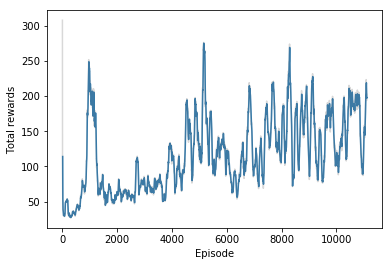

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

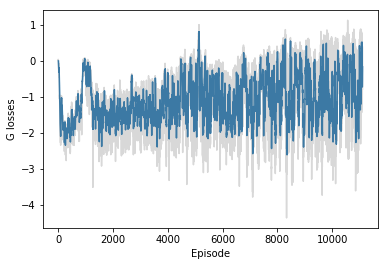

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

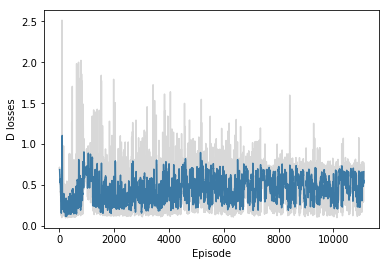

In [32]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.